# Ulusal Faktoring – Çek Default Tahmin Modeli

> **Hedef:** AUC ≥ 0.75 ile çek temerrüt tahmini
>
> **Metodoloji:** Temporal validation, segment-aware FE, Optuna-tuned GBM

## 1. Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    f1_score, confusion_matrix, classification_report, brier_score_loss
)
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier
from lofo import LOFOImportance, Dataset

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print('Setup complete.')

Setup complete.


## 2. Data Loading & Overview

In [2]:
df = pd.read_excel('UF_DS_case.xlsx')
print(f'Shape: {df.shape}')
print(f'\nColumns: {list(df.columns)}')
df.head()

Shape: (100000, 20)

Columns: ['Unnamed: 0', 'ID', 'term', 'branch_segment', 'founder age', 'company age', 'days_due', 'target', 'risk_other_factoring', 'cust_tenure', 'drawer_interest_accumulated', 'amount', 'cust_first_offer_flag', 'drawer_unpaidcheckcount', 'drawer_unpaid_ratio', 'cust_late_balance', 'drawer_last_redflag_date', 'drawer_creditbureauscore', 'drawer_max_balance_last12m', 'TERM']


,Unnamed: 0,ID,term,branch_segment,founder age,company age,days_due,target,risk_other_factoring,cust_tenure,drawer_interest_accumulated,amount,cust_first_offer_flag,drawer_unpaidcheckcount,drawer_unpaid_ratio,cust_late_balance,drawer_last_redflag_date,drawer_creditbureauscore,drawer_max_balance_last12m,TERM
0,0,1,202406,A,NaN,1.0,80,0,0,40,0.0,5.000000e+05,0,0.0,NaN,NaN,NaN,1796.0,2521406.0,202401
1,1,2,202505,D,NaN,17.0,89,0,6194211,1918,217208.0,2.373494e+06,0,0.0,NaN,NaN,NaN,NaN,2588845.0,202401
2,2,3,202506,A,57.0,NaN,49,0,1500000,2629,330.0,6.024096e+05,0,0.0,NaN,3327.0,NaN,NaN,9251623.0,202401
3,3,4,202507,D,37.0,NaN,37,0,0,0,372.0,3.012048e+06,1,0.0,NaN,12079.0,NaN,NaN,126915.0,202401
4,4,5,202409,A,NaN,14.0,70,0,24529632,1274,0.0,2.085692e+05,0,0.0,0.70142,NaN,NaN,NaN,18006011.0,202401


In [3]:
# Drop useless index column
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

print('Dtypes:')
print(df.dtypes)
print(f'\nShape after drop: {df.shape}')

Dtypes:
ID                               int64
term                             int64
branch_segment                     str
founder age                    float64
company age                    float64
days_due                         int64
target                           int64
risk_other_factoring             int64
cust_tenure                      int64
drawer_interest_accumulated    float64
amount                         float64
cust_first_offer_flag            int64
drawer_unpaidcheckcount        float64
drawer_unpaid_ratio            float64
cust_late_balance              float64
drawer_last_redflag_date       float64
drawer_creditbureauscore       float64
drawer_max_balance_last12m     float64
TERM                             int64
dtype: object

Shape after drop: (100000, 19)


## 3. Exploratory Data Analysis (EDA)

### 3.1 Missing Value Analysis (MNAR Discovery)

Missing Rates:
drawer_last_redflag_date       0.9795
drawer_unpaid_ratio            0.8548
drawer_creditbureauscore       0.7490
cust_late_balance              0.7356
founder age                    0.7259
company age                    0.2756
drawer_max_balance_last12m     0.0164
drawer_unpaidcheckcount        0.0084
drawer_interest_accumulated    0.0068
dtype: float64


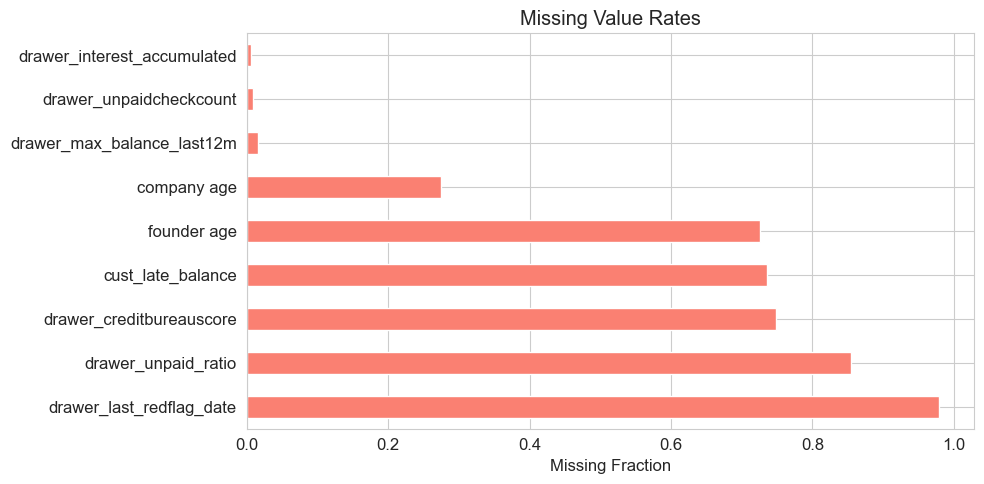

In [4]:
# Missing rates
missing = df.isnull().mean().sort_values(ascending=False)
print('Missing Rates:')
print(missing[missing > 0].round(4))

fig, ax = plt.subplots(figsize=(10, 5))
missing[missing > 0].plot(kind='barh', color='salmon', ax=ax)
ax.set_title('Missing Value Rates')
ax.set_xlabel('Missing Fraction')
plt.tight_layout()
plt.show()

In [5]:
# KEY DISCOVERY: Micro vs SME segment
# founder_age filled → Micro segment
# company_age filled → SME segment
# They are mutually exclusive!
both_filled = df['founder age'].notna() & df['company age'].notna()
print(f'Both founder_age AND company_age filled: {both_filled.sum()} rows')
print(f'founder_age filled (Micro): {df["founder age"].notna().sum():,}')
print(f'company_age filled (SME):   {df["company age"].notna().sum():,}')

# Missing correlation: drawer_unpaid_ratio missing ≈ unpaidcheckcount == 0
ratio_miss = df['drawer_unpaid_ratio'].isna()
check_zero = df['drawer_unpaidcheckcount'] == 0
print(f'\ndrawer_unpaid_ratio missing AND unpaidcheckcount==0: {(ratio_miss & check_zero).mean():.4f}')
print('→ Missingness is NOT random (MNAR). It means NO check history.')

Both founder_age AND company_age filled: 0 rows
founder_age filled (Micro): 27,409
company_age filled (SME):   72,445

drawer_unpaid_ratio missing AND unpaidcheckcount==0: 0.8432
→ Missingness is NOT random (MNAR). It means NO check history.


### 3.2 Target Distribution

Target Distribution:
target
0    94131
1     5869
Name: count, dtype: int64

Default Rate: 0.0587 (5.87%)
Imbalance Ratio: 16.0:1


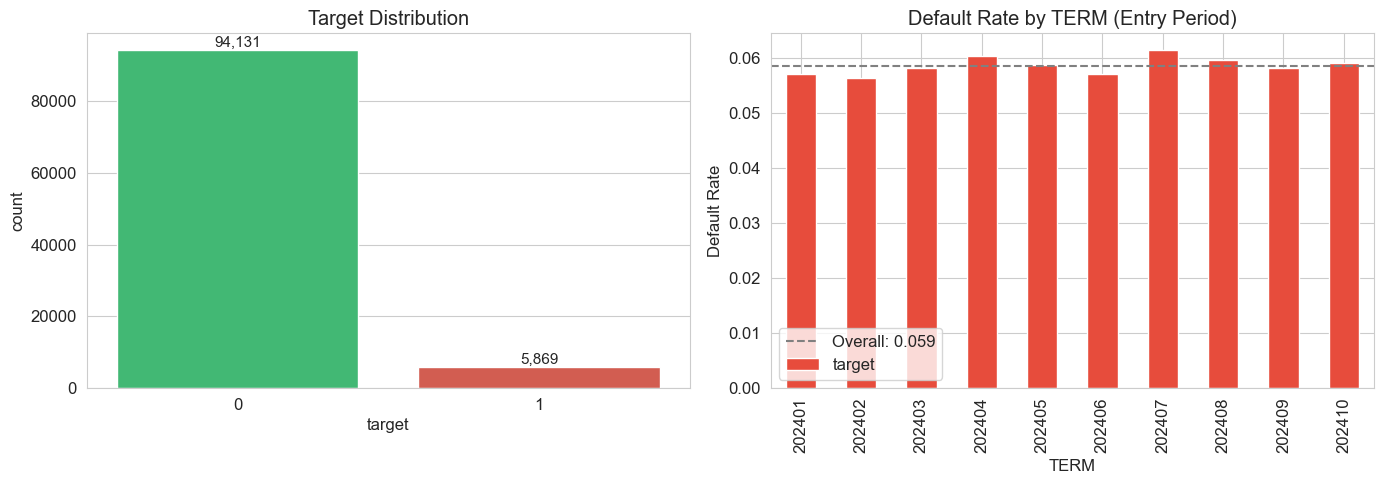

In [6]:
target_counts = df['target'].value_counts()
default_rate = df['target'].mean()
print(f'Target Distribution:\n{target_counts}')
print(f'\nDefault Rate: {default_rate:.4f} ({default_rate*100:.2f}%)')
print(f'Imbalance Ratio: {target_counts[0]/target_counts[1]:.1f}:1')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Bar
sns.countplot(x='target', data=df, palette=['#2ecc71','#e74c3c'], ax=axes[0])
axes[0].set_title('Target Distribution')
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height()):,}', (p.get_x()+p.get_width()/2., p.get_height()),
                     ha='center', va='bottom', fontsize=11)

# Default rate by TERM
term_dr = df.groupby('TERM')['target'].mean()
term_dr.plot(kind='bar', color='#e74c3c', ax=axes[1])
axes[1].set_title('Default Rate by TERM (Entry Period)')
axes[1].set_ylabel('Default Rate')
axes[1].axhline(default_rate, ls='--', color='gray', label=f'Overall: {default_rate:.3f}')
axes[1].legend()
plt.tight_layout()
plt.show()

### 3.3 Segment & Branch Analysis

Default Rate by Segment:
          DefaultRate  Total  Defaults
_segment                              
MICRO          0.0551  27409      1510
SME            0.0600  72591      4359

Default Rate by Branch Segment:
                DefaultRate  Total  Defaults
branch_segment                              
A                    0.0532  66227      3524
B                    0.0710   5308       377
C                    0.0616  14604       900
D                    0.0771  13861      1068


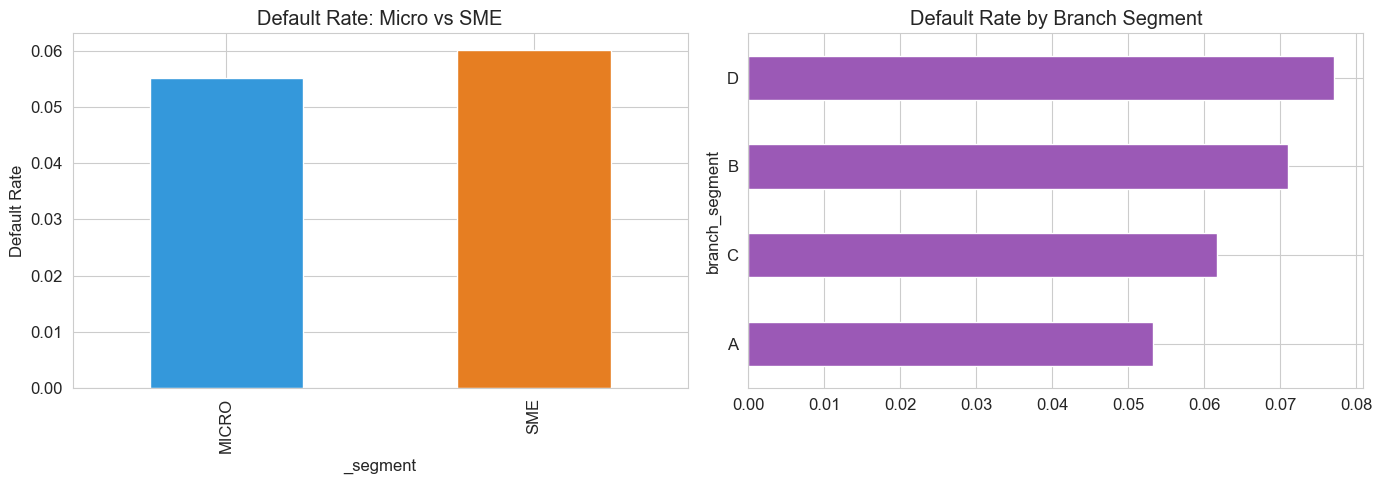

In [7]:
# Micro vs SME
df['_segment'] = np.where(df['founder age'].notna(), 'MICRO', 'SME')
seg_dr = df.groupby('_segment')['target'].agg(['mean','count','sum'])
seg_dr.columns = ['DefaultRate', 'Total', 'Defaults']
print('Default Rate by Segment:')
print(seg_dr.round(4))

# Branch segment
branch_dr = df.groupby('branch_segment')['target'].agg(['mean','count','sum'])
branch_dr.columns = ['DefaultRate', 'Total', 'Defaults']
print('\nDefault Rate by Branch Segment:')
print(branch_dr.round(4))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
seg_dr['DefaultRate'].plot(kind='bar', color=['#3498db','#e67e22'], ax=axes[0])
axes[0].set_title('Default Rate: Micro vs SME')
axes[0].set_ylabel('Default Rate')
branch_dr['DefaultRate'].sort_values().plot(kind='barh', color='#9b59b6', ax=axes[1])
axes[1].set_title('Default Rate by Branch Segment')
plt.tight_layout()
plt.show()

df.drop(columns=['_segment'], inplace=True)  # cleanup

### 3.4 Key Feature vs Target Analysis

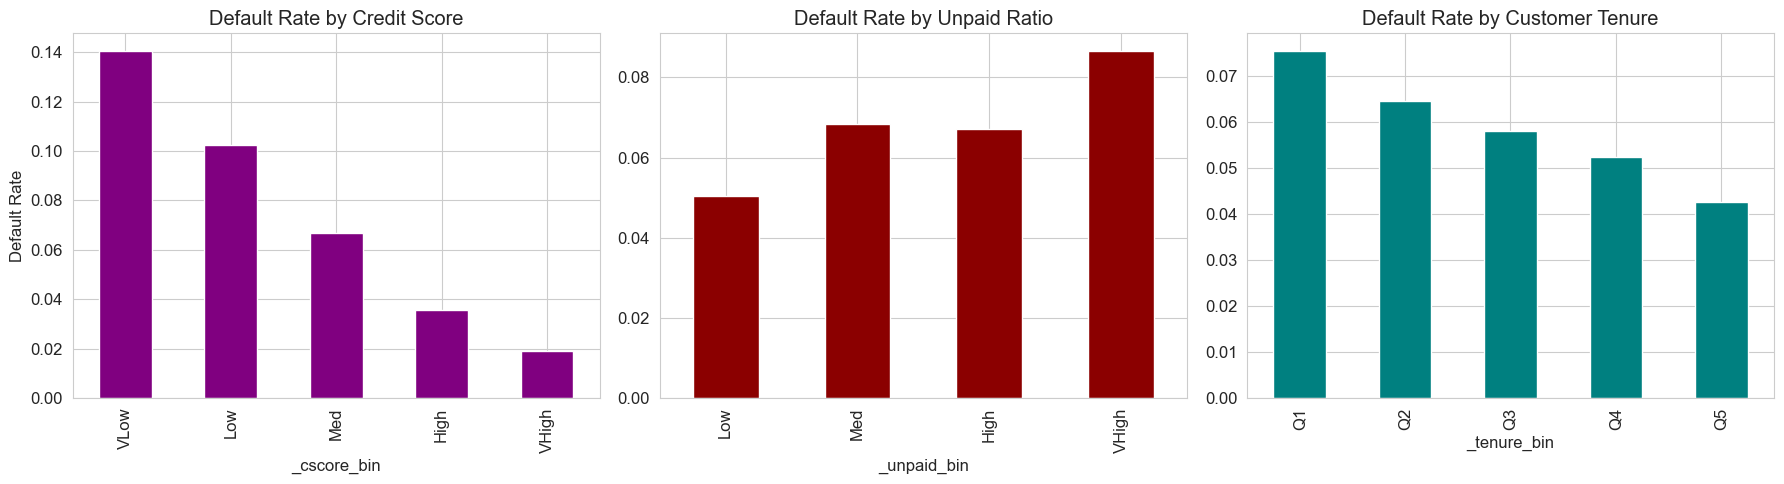

In [8]:
# Credit score vs default
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Credit score bins
df['_cscore_bin'] = pd.cut(df['drawer_creditbureauscore'],
    bins=[0, 1000, 1200, 1400, 1600, 2000], labels=['VLow','Low','Med','High','VHigh'])
cs_dr = df.groupby('_cscore_bin', observed=True)['target'].mean()
cs_dr.plot(kind='bar', color='purple', ax=axes[0])
axes[0].set_title('Default Rate by Credit Score')
axes[0].set_ylabel('Default Rate')

# 2. Unpaid ratio bins
df['_unpaid_bin'] = pd.cut(df['drawer_unpaid_ratio'],
    bins=[0, 0.1, 0.3, 0.5, 1.0], labels=['Low','Med','High','VHigh'])
up_dr = df.groupby('_unpaid_bin', observed=True)['target'].mean()
up_dr.plot(kind='bar', color='darkred', ax=axes[1])
axes[1].set_title('Default Rate by Unpaid Ratio')

# 3. Tenure bins
df['_tenure_bin'] = pd.qcut(df['cust_tenure'], 5, labels=['Q1','Q2','Q3','Q4','Q5'], duplicates='drop')
ten_dr = df.groupby('_tenure_bin', observed=True)['target'].mean()
ten_dr.plot(kind='bar', color='teal', ax=axes[2])
axes[2].set_title('Default Rate by Customer Tenure')

plt.tight_layout()
plt.show()

# Drop temp cols
df.drop(columns=['_cscore_bin','_unpaid_bin','_tenure_bin'], inplace=True)

### 3.5 Correlation with Target

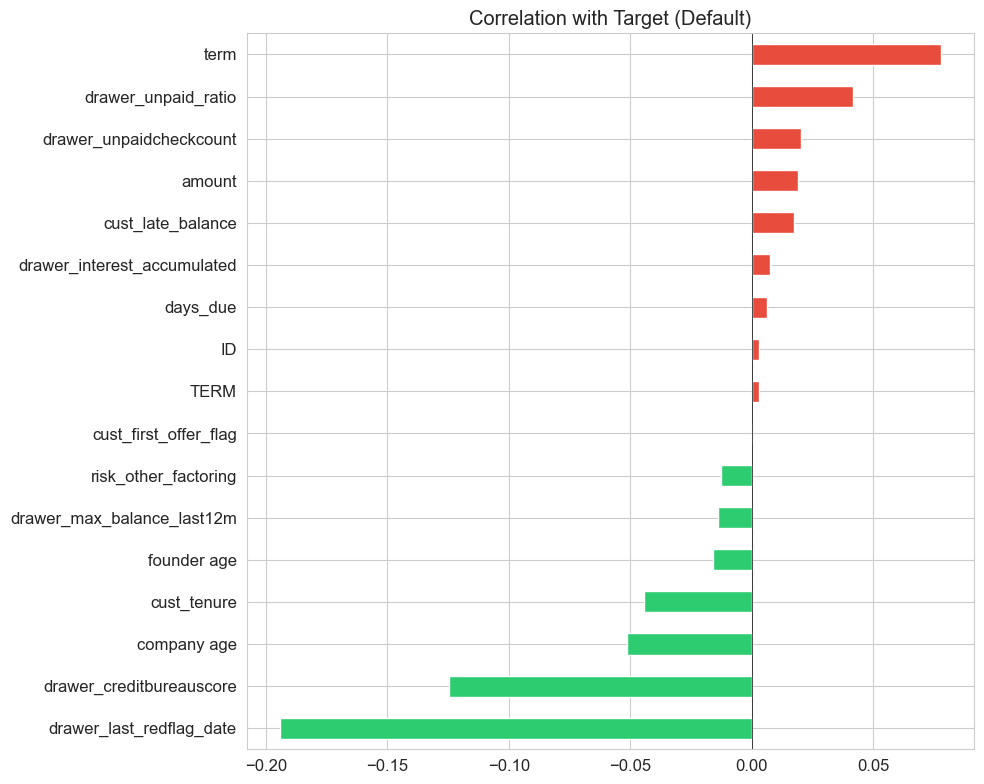

In [9]:
num_cols = df.select_dtypes(include='number').columns.tolist()
corr_target = df[num_cols].corr()['target'].drop('target').sort_values()

fig, ax = plt.subplots(figsize=(10, 8))
corr_target.plot(kind='barh', color=np.where(corr_target > 0, '#e74c3c', '#2ecc71'), ax=ax)
ax.set_title('Correlation with Target (Default)')
ax.axvline(0, color='black', lw=0.5)
plt.tight_layout()
plt.show()

## 4. Feature Engineering

### 4.1 Missing Flag Features (MNAR Handling)

In [10]:
df_fe = df.copy()
print(f'Starting FE: {df_fe.shape}')

# ── Missing Flags ──
df_fe['has_credit_score']   = df_fe['drawer_creditbureauscore'].notna().astype(int)
df_fe['has_unpaid_history'] = df_fe['drawer_unpaid_ratio'].notna().astype(int)
df_fe['has_redflag_history']= df_fe['drawer_last_redflag_date'].notna().astype(int)
df_fe['is_micro_segment']  = df_fe['founder age'].notna().astype(int)
df_fe['has_late_balance']   = (df_fe['cust_late_balance'].notna() & (df_fe['cust_late_balance'] > 0)).astype(int)

print('Missing flags created.')
for flag in ['has_credit_score','has_unpaid_history','has_redflag_history','is_micro_segment','has_late_balance']:
    dr_0 = df_fe.loc[df_fe[flag]==0, 'target'].mean()
    dr_1 = df_fe.loc[df_fe[flag]==1, 'target'].mean()
    print(f'  {flag}: {dr_0:.4f} (0) vs {dr_1:.4f} (1)  diff={abs(dr_0-dr_1):.4f}')

Starting FE: (100000, 19)
Missing flags created.
  has_credit_score: 0.0613 (0) vs 0.0508 (1)  diff=0.0106
  has_unpaid_history: 0.0566 (0) vs 0.0712 (1)  diff=0.0146
  has_redflag_history: 0.0575 (0) vs 0.1175 (1)  diff=0.0600
  is_micro_segment: 0.0600 (0) vs 0.0551 (1)  diff=0.0050
  has_late_balance: 0.0593 (0) vs 0.0555 (1)  diff=0.0038


### 4.2 Domain-Driven Features

In [11]:
# ── Temporal Features ──
df_fe['term_month'] = (df_fe['term'] % 100).astype(int)
df_fe['term_year']  = (df_fe['term'] // 100).astype(int)
df_fe['entry_month'] = (df_fe['TERM'] % 100).astype(int)

# Check maturity: months between entry and maturity
df_fe['check_maturity_months'] = (
    (df_fe['term_year'] - df_fe['TERM'] // 100) * 12 +
    (df_fe['term_month'] - df_fe['TERM'] % 100)
)

# ── Log transforms for skewed features ──
df_fe['amount_log'] = np.log1p(df_fe['amount'])
df_fe['risk_other_log'] = np.log1p(df_fe['risk_other_factoring'])
df_fe['max_balance_log'] = np.log1p(df_fe['drawer_max_balance_last12m'].fillna(0))
df_fe['interest_log'] = np.log1p(df_fe['drawer_interest_accumulated'].fillna(0))

# ── Ratio / Interaction Features ──
df_fe['amount_to_max_balance'] = df_fe['amount'] / (df_fe['drawer_max_balance_last12m'].fillna(0) + 1)
df_fe['amount_to_risk_ratio']  = df_fe['amount'] / (df_fe['risk_other_factoring'] + 1)
df_fe['unpaid_severity'] = df_fe['drawer_unpaidcheckcount'].fillna(0) * df_fe['drawer_unpaid_ratio'].fillna(0)

# ── Entity age (unified) ──
df_fe['entity_age'] = df_fe['founder age'].fillna(df_fe['company age'])

# ── Customer risk indicators ──
df_fe['is_new_customer'] = (df_fe['cust_tenure'] < df_fe['cust_tenure'].quantile(0.25)).astype(int)
df_fe['is_first_offer']  = df_fe['cust_first_offer_flag'].astype(int)

# ── Segment-specific features ──
df_fe['founder_age_risk'] = 0
mask_micro = df_fe['founder age'].notna()
df_fe.loc[mask_micro, 'founder_age_risk'] = (
    (df_fe.loc[mask_micro, 'founder age'] < 30) |
    (df_fe.loc[mask_micro, 'founder age'] > 60)
).astype(int)

df_fe['young_company'] = 0
mask_sme = df_fe['company age'].notna()
df_fe.loc[mask_sme, 'young_company'] = (df_fe.loc[mask_sme, 'company age'] < 3).astype(int)

# ── Redflag recency ──
df_fe['redflag_recency'] = (df_fe['TERM'] - df_fe['drawer_last_redflag_date']).fillna(9999)
df_fe['is_recent_defaulter'] = (df_fe['redflag_recency'] < 6).astype(int)

# ── tenure * amount interaction ──
df_fe['tenure_amount_interaction'] = df_fe['cust_tenure'] * df_fe['amount_log']

print(f'FE complete. Shape: {df_fe.shape}')

FE complete. Shape: (100000, 43)


## 5. Preprocessing & Temporal Split

### 5.1 Imputation & Encoding

In [12]:
# ── Columns to drop ──
drop_cols = ['ID', 'term', 'TERM', 'branch_segment',
             'founder age', 'company age',
             'drawer_last_redflag_date',  # replaced by recency features
             'term_year']  # leakage-prone, entry_month enough

# Store TERM and branch_segment for split and encoding before dropping
term_series = df_fe['TERM'].copy()
branch_series = df_fe['branch_segment'].copy()

# One-Hot Encode branch_segment
branch_dummies = pd.get_dummies(branch_series, prefix='branch', drop_first=True).astype(int)
df_fe = pd.concat([df_fe, branch_dummies], axis=1)

# Drop columns
df_fe = df_fe.drop(columns=[c for c in drop_cols if c in df_fe.columns])

print(f'After encoding & drops: {df_fe.shape}')
print(f'Columns: {list(df_fe.columns)}')

After encoding & drops: (100000, 38)
Columns: ['days_due', 'target', 'risk_other_factoring', 'cust_tenure', 'drawer_interest_accumulated', 'amount', 'cust_first_offer_flag', 'drawer_unpaidcheckcount', 'drawer_unpaid_ratio', 'cust_late_balance', 'drawer_creditbureauscore', 'drawer_max_balance_last12m', 'has_credit_score', 'has_unpaid_history', 'has_redflag_history', 'is_micro_segment', 'has_late_balance', 'term_month', 'entry_month', 'check_maturity_months', 'amount_log', 'risk_other_log', 'max_balance_log', 'interest_log', 'amount_to_max_balance', 'amount_to_risk_ratio', 'unpaid_severity', 'entity_age', 'is_new_customer', 'is_first_offer', 'founder_age_risk', 'young_company', 'redflag_recency', 'is_recent_defaulter', 'tenure_amount_interaction', 'branch_B', 'branch_C', 'branch_D']


### 5.2 Temporal Train / Validation / Test Split

In [13]:
# Temporal split using TERM
train_mask = term_series <= 202407
val_mask   = term_series == 202408
test_mask  = term_series >= 202409

target_col = 'target'
feature_cols = [c for c in df_fe.columns if c != target_col]

X_train = df_fe.loc[train_mask, feature_cols].copy()
y_train = df_fe.loc[train_mask, target_col].copy()
X_val   = df_fe.loc[val_mask,   feature_cols].copy()
y_val   = df_fe.loc[val_mask,   target_col].copy()
X_test  = df_fe.loc[test_mask,  feature_cols].copy()
y_test  = df_fe.loc[test_mask,  target_col].copy()

print(f'Train: {X_train.shape}  (default rate: {y_train.mean():.4f})')
print(f'Val:   {X_val.shape}  (default rate: {y_val.mean():.4f})')
print(f'Test:  {X_test.shape}  (default rate: {y_test.mean():.4f})')

Train: (70000, 37)  (default rate: 0.0585)
Val:   (10000, 37)  (default rate: 0.0598)
Test:  (20000, 37)  (default rate: 0.0587)


### 5.3 Imputation (Train-Only Statistics)

In [14]:
# Calculate imputation values FROM TRAIN ONLY (no leakage)
impute_median_cols = ['drawer_creditbureauscore', 'drawer_interest_accumulated',
                      'drawer_unpaidcheckcount', 'drawer_max_balance_last12m',
                      'entity_age', 'redflag_recency']
impute_zero_cols = ['drawer_unpaid_ratio', 'cust_late_balance']

# Compute medians from train
train_medians = {}
for col in impute_median_cols:
    if col in X_train.columns:
        train_medians[col] = X_train[col].median()

# Apply to all sets
for ds_name, ds in [('Train', X_train), ('Val', X_val), ('Test', X_test)]:
    for col, med_val in train_medians.items():
        ds[col] = ds[col].fillna(med_val)
    for col in impute_zero_cols:
        if col in ds.columns:
            ds[col] = ds[col].fillna(0)
    # Fill any remaining NaNs with 0
    remaining_na = ds.isnull().sum().sum()
    if remaining_na > 0:
        ds.fillna(0, inplace=True)
        print(f'  {ds_name}: filled {remaining_na} remaining NaNs with 0')

print(f'Imputation done. Remaining NaN — Train: {X_train.isnull().sum().sum()}, Val: {X_val.isnull().sum().sum()}, Test: {X_test.isnull().sum().sum()}')

Imputation done. Remaining NaN — Train: 0, Val: 0, Test: 0


## 6. Baseline Model & Feature Selection

In [15]:
from lightgbm import LGBMClassifier

# ── Baseline LightGBM ──
# Using scale_pos_weight for consistency with Optuna tuning
_imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(f'Imbalance ratio: {_imbalance_ratio:.1f}:1 → using scale_pos_weight={_imbalance_ratio:.1f}')

baseline_lgbm = LGBMClassifier(
    n_estimators=300,
    scale_pos_weight=_imbalance_ratio,
    random_state=RANDOM_STATE,
    verbose=-1,
    n_jobs=-1
)
baseline_lgbm.fit(X_train, y_train)

# Evaluate on validation
val_preds_base = baseline_lgbm.predict_proba(X_val)[:, 1]
test_preds_base = baseline_lgbm.predict_proba(X_test)[:, 1]
val_auc = roc_auc_score(y_val, val_preds_base)
test_auc = roc_auc_score(y_test, test_preds_base)
print(f'Baseline LightGBM — Val AUC: {val_auc:.4f} | Test AUC: {test_auc:.4f}')
print(f'Note: Baseline uses actual imbalance ratio. Optuna will tune scale_pos_weight [1, 16].')

Imbalance ratio: 16.1:1 → using scale_pos_weight=16.1
Baseline LightGBM — Val AUC: 0.6850 | Test AUC: 0.7075
Note: Baseline uses actual imbalance ratio. Optuna will tune scale_pos_weight [1, 16].


### 6.1 Feature Importance (LOFO - Leave One Feature Out)

  0%|          | 0/37 [00:00<?, ?it/s]

LOFO Importance computed for 37 features


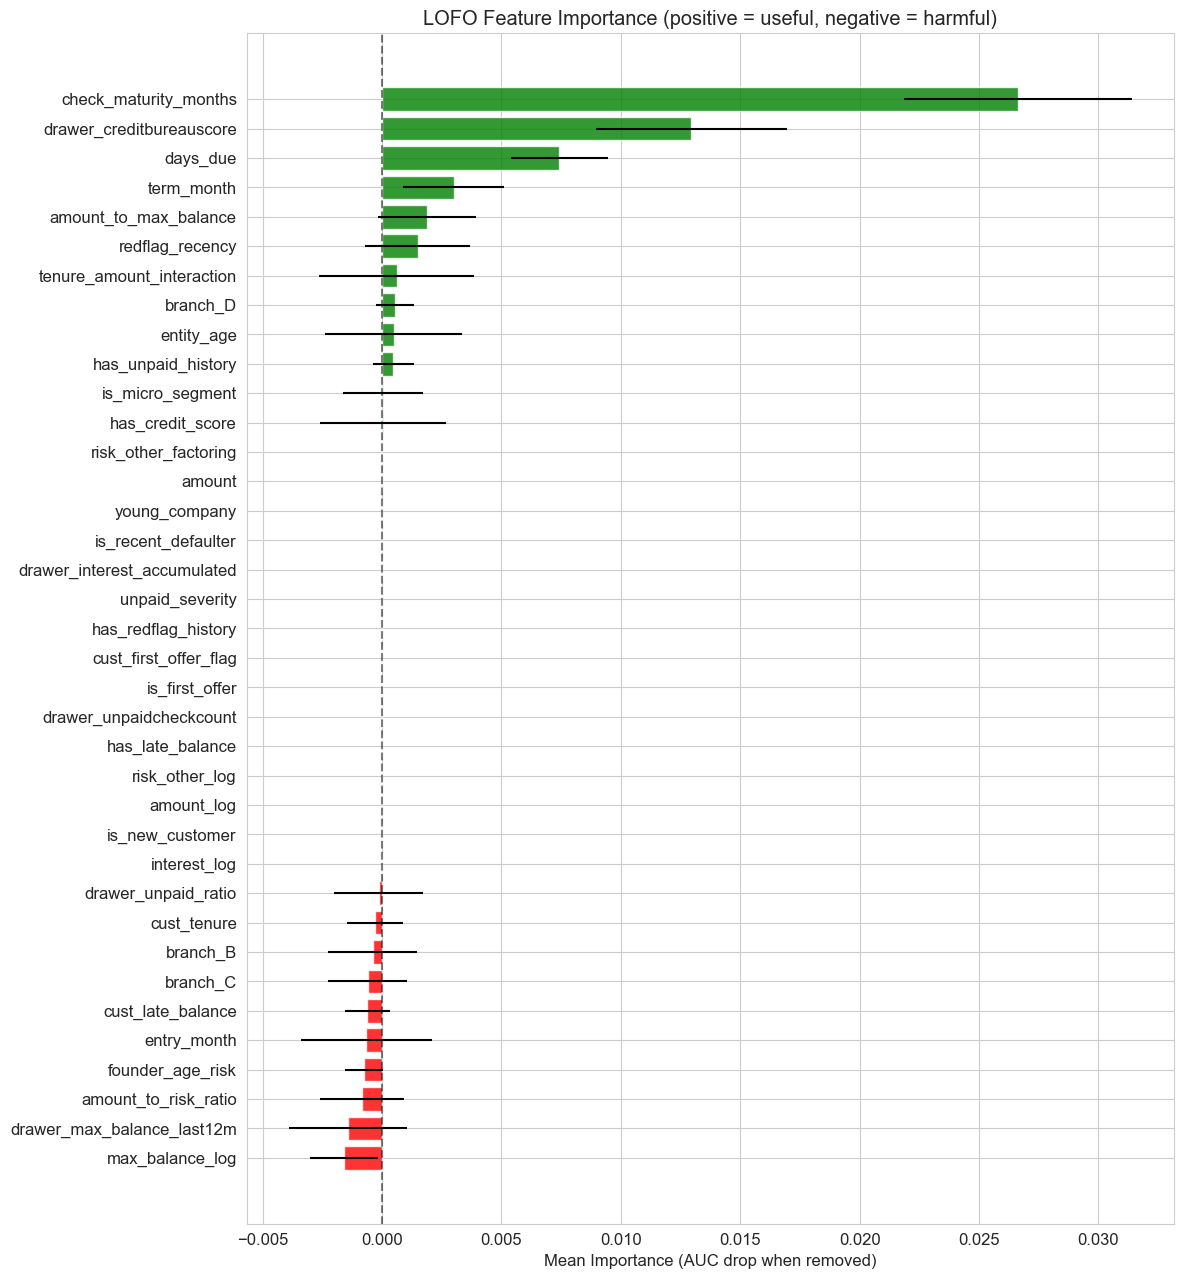


Keeping 35 features, dropping 2: ['drawer_max_balance_last12m', 'max_balance_log']


In [16]:
# -- LOFO Importance --
# LOFO measures each feature's contribution by removing it and measuring
# the drop in model performance. More robust than permutation importance.

# Create LOFO dataset
df_lofo = X_train.copy()
df_lofo['target'] = y_train.values

lofo_dataset = Dataset(
    df=df_lofo,
    target='target',
    features=[c for c in feature_cols]
)

# Run LOFO with LightGBM as the base estimator
lofo_imp = LOFOImportance(
    dataset=lofo_dataset,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1
)

lofo_result = lofo_imp.get_importance()
print(f'LOFO Importance computed for {len(lofo_result)} features')

# Visualize
fig, ax = plt.subplots(figsize=(12, max(8, len(lofo_result)*0.35)))
lofo_result_sorted = lofo_result.sort_values('importance_mean', ascending=True)
colors = ['green' if x > 0 else 'red' for x in lofo_result_sorted['importance_mean']]
ax.barh(lofo_result_sorted['feature'], lofo_result_sorted['importance_mean'],
        xerr=lofo_result_sorted['importance_std'], color=colors, alpha=0.8)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax.set_title('LOFO Feature Importance (positive = useful, negative = harmful)')
ax.set_xlabel('Mean Importance (AUC drop when removed)')
plt.tight_layout()
plt.show()

# Features to keep: positive or near-zero LOFO importance
# Drop only clearly harmful features (importance < -0.001)
keep_features = lofo_result[lofo_result['importance_mean'] >= -0.001]['feature'].tolist()
dropped = [f for f in feature_cols if f not in keep_features]
print(f'\nKeeping {len(keep_features)} features, dropping {len(dropped)}: {dropped}')

In [17]:
# Apply feature selection
X_train_sel = X_train[keep_features]
X_val_sel   = X_val[keep_features]
X_test_sel  = X_test[keep_features]
print(f'Selected feature set: {X_train_sel.shape}')

Selected feature set: (70000, 35)


## 7. Hyperparameter Tuning (Optuna - AUC)

### 7.1 LightGBM Optimization

In [18]:
import optuna
from sklearn.metrics import f1_score, precision_recall_curve
optuna.logging.set_verbosity(optuna.logging.WARNING)

def lgbm_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 127),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 16.0),
        'verbose': -1,
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }
    model = LGBMClassifier(**params)
    model.fit(X_train_sel, y_train)
    preds = model.predict_proba(X_val_sel)[:, 1]
    return roc_auc_score(y_val, preds)

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(lgbm_objective, n_trials=50, show_progress_bar=True)
print(f'\nBest LightGBM Val AUC: {study_lgbm.best_value:.4f}')
print(f'Best Params: {study_lgbm.best_params}')

  0%|          | 0/50 [00:00<?, ?it/s]


Best LightGBM Val AUC: 0.7161
Best Params: {'n_estimators': 269, 'max_depth': 6, 'learning_rate': 0.03023324372534472, 'num_leaves': 124, 'min_child_samples': 129, 'subsample': 0.6421143886315458, 'colsample_bytree': 0.7267075477070796, 'reg_alpha': 0.0014893067903989463, 'reg_lambda': 0.2823539105629799, 'scale_pos_weight': 11.658213484499488}


### 7.2 CatBoost Optimization

In [19]:
from catboost import CatBoostClassifier

def catboost_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 800),
        'depth': trial.suggest_int('depth', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 16.0),
        'border_count': 128,
        'verbose': 0,
        'random_state': RANDOM_STATE,
        'allow_writing_files': False,
        'thread_count': -1
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train_sel, y_train)
    preds = model.predict_proba(X_val_sel)[:, 1]
    return roc_auc_score(y_val, preds)

study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(catboost_objective, n_trials=50, show_progress_bar=True)
print(f'\nBest CatBoost Val AUC: {study_cb.best_value:.4f}')
print(f'Best Params: {study_cb.best_params}')

  0%|          | 0/50 [00:00<?, ?it/s]


Best CatBoost Val AUC: 0.7160
Best Params: {'iterations': 502, 'depth': 5, 'learning_rate': 0.042389380568059735, 'l2_leaf_reg': 1.127274090469904, 'scale_pos_weight': 6.318388339894787}


### 7.3 XGBoost Optimization

In [20]:
from xgboost import XGBClassifier

def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 16.0),
        'eval_metric': 'logloss',
        'verbosity': 0,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'use_label_encoder': False
    }
    model = XGBClassifier(**params)
    model.fit(X_train_sel, y_train)
    preds = model.predict_proba(X_val_sel)[:, 1]
    return roc_auc_score(y_val, preds)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(xgb_objective, n_trials=50, show_progress_bar=True)
print(f'\nBest XGBoost Val AUC: {study_xgb.best_value:.4f}')
print(f'Best Params: {study_xgb.best_params}')

  0%|          | 0/50 [00:00<?, ?it/s]


Best XGBoost Val AUC: 0.7185
Best Params: {'n_estimators': 711, 'max_depth': 5, 'learning_rate': 0.01691357524688423, 'min_child_weight': 2, 'subsample': 0.8063877926129728, 'colsample_bytree': 0.8048123893628572, 'gamma': 0.8198351179349554, 'reg_alpha': 0.009215905190234956, 'reg_lambda': 0.22101614910654804, 'scale_pos_weight': 2.5689265261421728}


## 8. Final Models & Ensemble

In [21]:
# ── Train final models with best params ──

# LightGBM
best_lgbm_params = study_lgbm.best_params.copy()
best_lgbm_params.update({'verbose': -1, 'random_state': RANDOM_STATE, 'n_jobs': -1})
final_lgbm = LGBMClassifier(**best_lgbm_params)
final_lgbm.fit(X_train_sel, y_train)

# CatBoost
best_cb_params = study_cb.best_params.copy()
best_cb_params.update({'verbose': 0, 'random_state': RANDOM_STATE,
                       'allow_writing_files': False, 'thread_count': -1, 'border_count': 128})
final_catboost = CatBoostClassifier(**best_cb_params)
final_catboost.fit(X_train_sel, y_train)

# XGBoost
best_xgb_params = study_xgb.best_params.copy()
best_xgb_params.update({'verbosity': 0, 'random_state': RANDOM_STATE, 'n_jobs': -1,
                        'eval_metric': 'logloss', 'use_label_encoder': False})
final_xgboost = XGBClassifier(**best_xgb_params)
final_xgboost.fit(X_train_sel, y_train)

# ── Predictions ──
lgbm_val_pred  = final_lgbm.predict_proba(X_val_sel)[:, 1]
lgbm_test_pred = final_lgbm.predict_proba(X_test_sel)[:, 1]
cb_val_pred    = final_catboost.predict_proba(X_val_sel)[:, 1]
cb_test_pred   = final_catboost.predict_proba(X_test_sel)[:, 1]
xgb_val_pred   = final_xgboost.predict_proba(X_val_sel)[:, 1]
xgb_test_pred  = final_xgboost.predict_proba(X_test_sel)[:, 1]

# ── Ensemble (weighted average, weight by val AUC) ──
lgbm_val_auc = roc_auc_score(y_val, lgbm_val_pred)
cb_val_auc   = roc_auc_score(y_val, cb_val_pred)
xgb_val_auc  = roc_auc_score(y_val, xgb_val_pred)
total = lgbm_val_auc + cb_val_auc + xgb_val_auc
w_lgbm = lgbm_val_auc / total
w_cb   = cb_val_auc / total
w_xgb  = xgb_val_auc / total

ensemble_test_pred = w_lgbm * lgbm_test_pred + w_cb * cb_test_pred + w_xgb * xgb_test_pred
ensemble_val_pred  = w_lgbm * lgbm_val_pred  + w_cb * cb_val_pred  + w_xgb * xgb_val_pred

print('=== FINAL RESULTS (AUC) ===')
print(f'LightGBM    — Val AUC: {lgbm_val_auc:.4f} | Test AUC: {roc_auc_score(y_test, lgbm_test_pred):.4f}')
print(f'CatBoost    — Val AUC: {cb_val_auc:.4f} | Test AUC: {roc_auc_score(y_test, cb_test_pred):.4f}')
print(f'XGBoost     — Val AUC: {xgb_val_auc:.4f} | Test AUC: {roc_auc_score(y_test, xgb_test_pred):.4f}')
ens_test_auc = roc_auc_score(y_test, ensemble_test_pred)
print(f'Ensemble    — Val AUC: {roc_auc_score(y_val, ensemble_val_pred):.4f} | Test AUC: {ens_test_auc:.4f}')
print(f'\nWeights: LightGBM={w_lgbm:.3f}, CatBoost={w_cb:.3f}, XGBoost={w_xgb:.3f}')
print(f'Gini: {2*ens_test_auc - 1:.4f}')
print(f'\nNote: F1 optimization is done separately via threshold tuning in Section 9.5')

=== FINAL RESULTS (AUC) ===
LightGBM    — Val AUC: 0.7161 | Test AUC: 0.7263
CatBoost    — Val AUC: 0.7160 | Test AUC: 0.7270
XGBoost     — Val AUC: 0.7185 | Test AUC: 0.7289
Ensemble    — Val AUC: 0.7194 | Test AUC: 0.7298

Weights: LightGBM=0.333, CatBoost=0.333, XGBoost=0.334
Gini: 0.4597

Note: F1 optimization is done separately via threshold tuning in Section 9.5


### 8.1 Cross-Validation Stability (StratifiedKFold)

=== CROSS-VALIDATION STABILITY (StratifiedKFold, 5 folds) ===
LightGBM:
  Fold 1: AUC = 0.7191
  Fold 2: AUC = 0.7114
  Fold 3: AUC = 0.7208
  Fold 4: AUC = 0.7317
  Fold 5: AUC = 0.7132
  Mean: 0.7192 +/- 0.0071
CatBoost:
  Fold 1: AUC = 0.7187
  Fold 2: AUC = 0.7168
  Fold 3: AUC = 0.7216
  Fold 4: AUC = 0.7310
  Fold 5: AUC = 0.7111
  Mean: 0.7198 +/- 0.0066
XGBoost:
  Fold 1: AUC = 0.7222
  Fold 2: AUC = 0.7164
  Fold 3: AUC = 0.7263
  Fold 4: AUC = 0.7358
  Fold 5: AUC = 0.7166
  Mean: 0.7234 +/- 0.0072


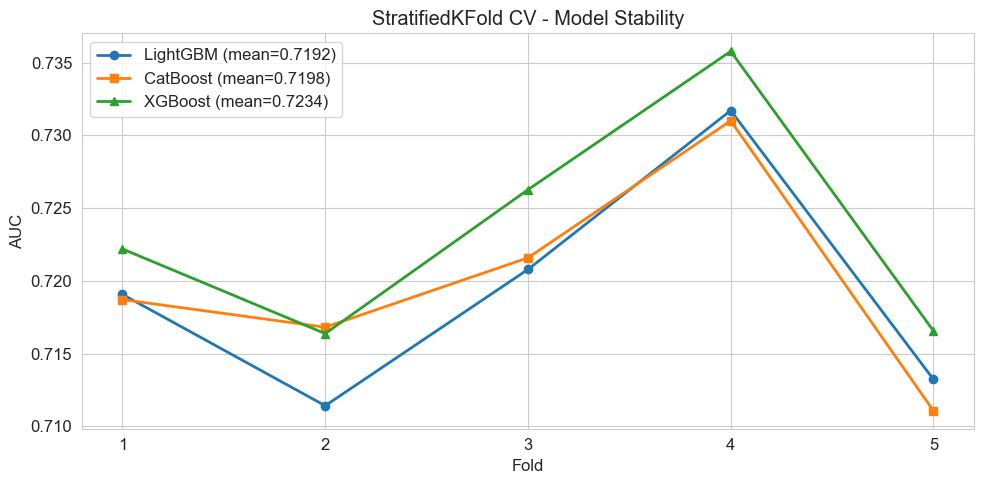

In [22]:
# -- StratifiedKFold CV on Train set for stability analysis --
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = {'LightGBM': [], 'CatBoost': [], 'XGBoost': []}

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_sel, y_train), 1):
    X_tr, X_va = X_train_sel.iloc[tr_idx], X_train_sel.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    
    # LightGBM
    _lgbm = LGBMClassifier(**{**best_lgbm_params, 'verbose': -1, 'random_state': RANDOM_STATE, 'n_jobs': -1})
    _lgbm.fit(X_tr, y_tr)
    cv_results['LightGBM'].append(roc_auc_score(y_va, _lgbm.predict_proba(X_va)[:, 1]))
    
    # CatBoost
    _cb = CatBoostClassifier(**{**best_cb_params, 'verbose': 0, 'random_state': RANDOM_STATE,
                                'allow_writing_files': False, 'thread_count': -1, 'border_count': 128})
    _cb.fit(X_tr, y_tr)
    cv_results['CatBoost'].append(roc_auc_score(y_va, _cb.predict_proba(X_va)[:, 1]))
    
    # XGBoost
    _xgb = XGBClassifier(**{**best_xgb_params, 'verbosity': 0, 'random_state': RANDOM_STATE,
                            'n_jobs': -1, 'eval_metric': 'logloss', 'use_label_encoder': False})
    _xgb.fit(X_tr, y_tr)
    cv_results['XGBoost'].append(roc_auc_score(y_va, _xgb.predict_proba(X_va)[:, 1]))

print('=== CROSS-VALIDATION STABILITY (StratifiedKFold, 5 folds) ===')
for model_name, scores in cv_results.items():
    print(f'{model_name}:')
    for i, s in enumerate(scores, 1):
        print(f'  Fold {i}: AUC = {s:.4f}')
    print(f'  Mean: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(1, 6)
ax.plot(x, cv_results['LightGBM'], 'o-', label=f"LightGBM (mean={np.mean(cv_results['LightGBM']):.4f})", lw=2)
ax.plot(x, cv_results['CatBoost'], 's-', label=f"CatBoost (mean={np.mean(cv_results['CatBoost']):.4f})", lw=2)
ax.plot(x, cv_results['XGBoost'], '^-', label=f"XGBoost (mean={np.mean(cv_results['XGBoost']):.4f})", lw=2)
ax.set_xlabel('Fold'); ax.set_ylabel('AUC')
ax.set_title('StratifiedKFold CV - Model Stability')
ax.set_xticks(x)
ax.legend()
plt.tight_layout()
plt.show()

In [23]:
# Overfitting check: Train AUC vs Test AUC gap
train_auc_lgbm = roc_auc_score(y_train, final_lgbm.predict_proba(X_train_sel)[:, 1])
train_auc_cb   = roc_auc_score(y_train, final_catboost.predict_proba(X_train_sel)[:, 1])
train_auc_xgb  = roc_auc_score(y_train, final_xgboost.predict_proba(X_train_sel)[:, 1])

print('=== OVERFITTING CHECK ===')
for name, tr_auc, te_pred in [('LightGBM', train_auc_lgbm, lgbm_test_pred),
                               ('CatBoost', train_auc_cb, cb_test_pred),
                               ('XGBoost', train_auc_xgb, xgb_test_pred)]:
    te_auc = roc_auc_score(y_test, te_pred)
    gap = tr_auc - te_auc
    flag = 'WARNING' if gap > 0.05 else 'OK'
    print(f'{name}: Train AUC={tr_auc:.4f} | Test AUC={te_auc:.4f} | Gap={gap:.4f} [{flag}]')

=== OVERFITTING CHECK ===
LightGBM: Train AUC=0.8263 | Test AUC=0.7263 | Gap=0.0999 [WARNING]
CatBoost: Train AUC=0.7932 | Test AUC=0.7270 | Gap=0.0662 [WARNING]
XGBoost: Train AUC=0.8310 | Test AUC=0.7289 | Gap=0.1021 [WARNING]


---

## 9. Comprehensive Model Evaluation

### 9.1 ROC & PR Curves

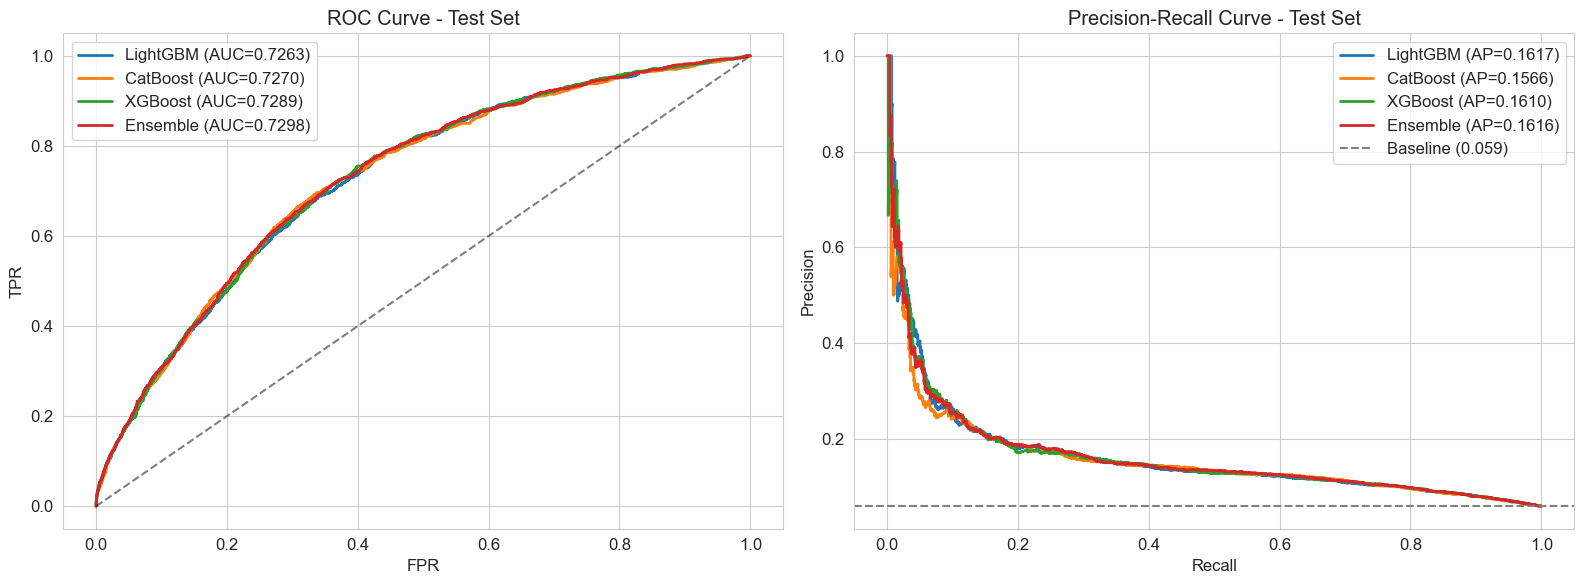

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ── ROC Curve ──
for name, preds in [('LightGBM', lgbm_test_pred), ('CatBoost', cb_test_pred),
                    ('XGBoost', xgb_test_pred), ('Ensemble', ensemble_test_pred)]:
    fpr, tpr, _ = roc_curve(y_test, preds)
    auc_val = roc_auc_score(y_test, preds)
    axes[0].plot(fpr, tpr, label=f'{name} (AUC={auc_val:.4f})', lw=2)
axes[0].plot([0,1],[0,1],'k--', alpha=0.5)
axes[0].set_title('ROC Curve - Test Set')
axes[0].set_xlabel('FPR'); axes[0].set_ylabel('TPR')
axes[0].legend()

# ── Precision-Recall Curve ──
for name, preds in [('LightGBM', lgbm_test_pred), ('CatBoost', cb_test_pred),
                    ('XGBoost', xgb_test_pred), ('Ensemble', ensemble_test_pred)]:
    prec, rec, _ = precision_recall_curve(y_test, preds)
    ap = average_precision_score(y_test, preds)
    axes[1].plot(rec, prec, label=f'{name} (AP={ap:.4f})', lw=2)
axes[1].axhline(y_test.mean(), ls='--', color='gray', label=f'Baseline ({y_test.mean():.3f})')
axes[1].set_title('Precision-Recall Curve - Test Set')
axes[1].set_xlabel('Recall'); axes[1].set_ylabel('Precision')
axes[1].legend()

plt.tight_layout()
plt.show()

### 9.2 KS Statistic

KS Statistic: 0.3539 at threshold index 1497


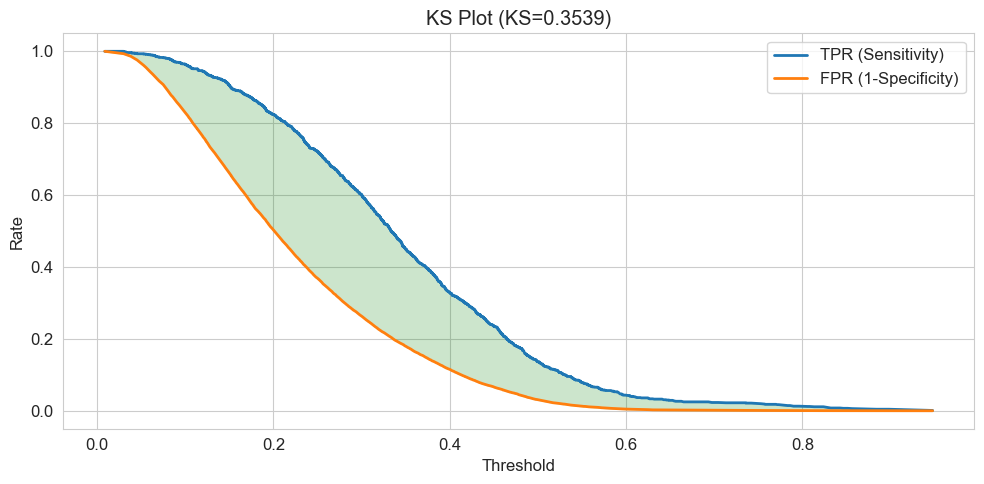

In [25]:
# KS Statistic
fpr, tpr, thresholds = roc_curve(y_test, ensemble_test_pred)
ks_stat = np.max(tpr - fpr)
ks_thresh_idx = np.argmax(tpr - fpr)
print(f'KS Statistic: {ks_stat:.4f} at threshold index {ks_thresh_idx}')

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(thresholds, tpr[:-1] if len(tpr) > len(thresholds) else tpr, label='TPR (Sensitivity)', lw=2)
ax.plot(thresholds, fpr[:-1] if len(fpr) > len(thresholds) else fpr, label='FPR (1-Specificity)', lw=2)
ax.fill_between(thresholds,
                tpr[:-1] if len(tpr) > len(thresholds) else tpr,
                fpr[:-1] if len(fpr) > len(thresholds) else fpr,
                alpha=0.2, color='green')
ax.set_title(f'KS Plot (KS={ks_stat:.4f})')
ax.set_xlabel('Threshold'); ax.set_ylabel('Rate')
ax.legend()
plt.tight_layout()
plt.show()

### 9.3 Calibration Curve

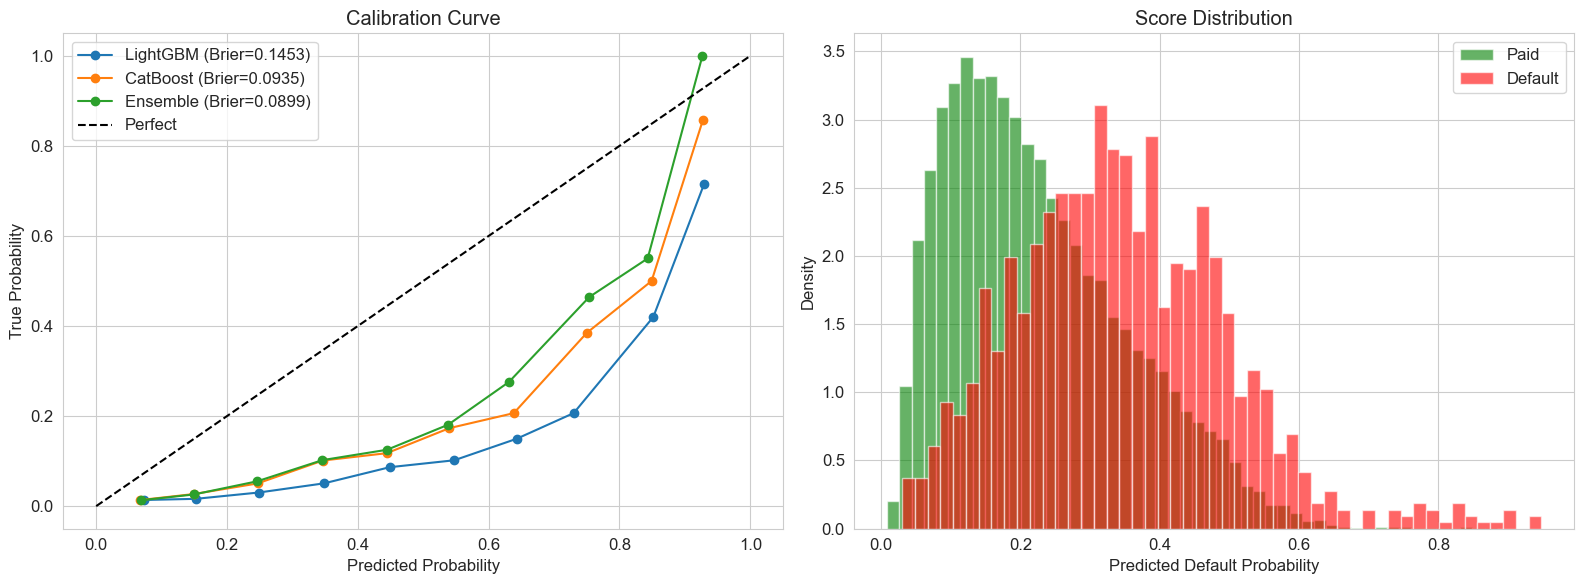

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calibration
for name, preds in [('LightGBM', lgbm_test_pred), ('CatBoost', cb_test_pred), ('Ensemble', ensemble_test_pred)]:
    prob_true, prob_pred = calibration_curve(y_test, preds, n_bins=10, strategy='uniform')
    brier = brier_score_loss(y_test, preds)
    axes[0].plot(prob_pred, prob_true, marker='o', label=f'{name} (Brier={brier:.4f})')
axes[0].plot([0,1],[0,1], 'k--', label='Perfect')
axes[0].set_title('Calibration Curve')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('True Probability')
axes[0].legend()

# Score Distribution
axes[1].hist(ensemble_test_pred[y_test==0], bins=50, alpha=0.6, label='Paid', color='green', density=True)
axes[1].hist(ensemble_test_pred[y_test==1], bins=50, alpha=0.6, label='Default', color='red', density=True)
axes[1].set_title('Score Distribution')
axes[1].set_xlabel('Predicted Default Probability')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.show()

### 9.4 PSI — Population Stability Index (Feature Drift)

=== POPULATION STABILITY INDEX (PSI) ===
Interpretation: <0.10 = stable, 0.10–0.25 = moderate shift, >0.25 = significant shift

  🔴 entry_month: 9.3731
  🔴 check_maturity_months: 0.3461
  🟢 term_month: 0.0006
  🟢 amount_to_max_balance: 0.0005
  🟢 amount_to_risk_ratio: 0.0005
  🟢 amount: 0.0005
  🟢 amount_log: 0.0005
  🟢 entity_age: 0.0004
  🟢 days_due: 0.0004
  🟢 risk_other_factoring: 0.0004
  🟢 risk_other_log: 0.0004
  🟢 cust_tenure: 0.0004
  🟢 drawer_interest_accumulated: 0.0003
  🟢 interest_log: 0.0003
  🟢 tenure_amount_interaction: 0.0003
  🟢 drawer_creditbureauscore: 0.0002
  🟢 cust_late_balance: 0.0001
  🟢 branch_C: 0.0000
  🟢 has_late_balance: 0.0000
  🟢 drawer_unpaid_ratio: 0.0000
  🟢 founder_age_risk: 0.0000
  🟢 branch_B: 0.0000
  🟢 redflag_recency: 0.0000
  🟢 drawer_unpaidcheckcount: 0.0000
  🟢 is_first_offer: 0.0000
  🟢 is_new_customer: 0.0000
  🟢 has_redflag_history: 0.0000
  🟢 unpaid_severity: 0.0000
  🟢 is_recent_defaulter: 0.0000
  🟢 young_company: 0.0000
  🟢 has_credit_

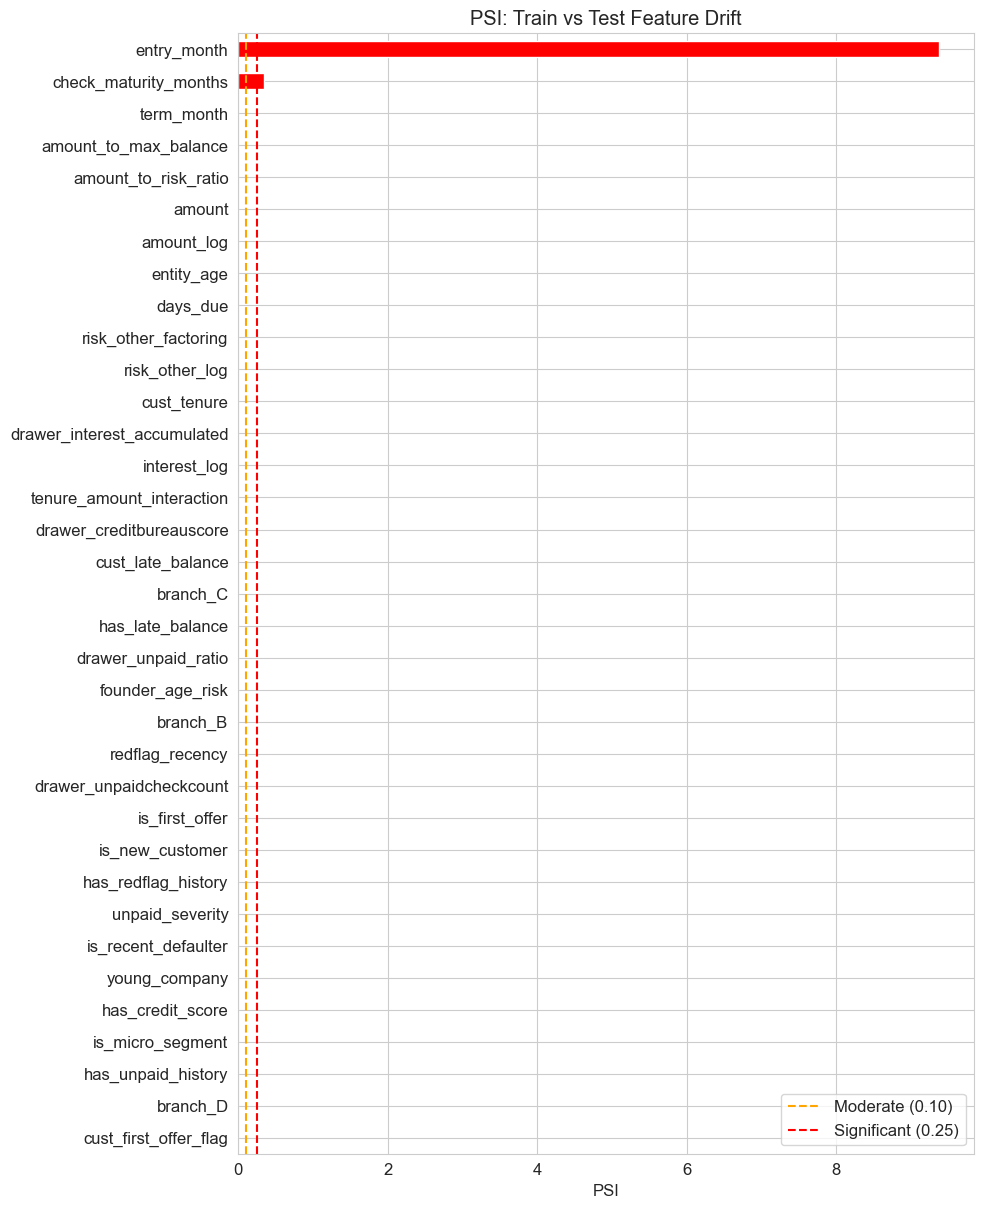


📊 Model Score PSI (train vs test predictions): 0.0041
✅ Score distribution is stable — model is safe to deploy


In [27]:
# ── PSI: measures distribution shift between train and test ──
def calculate_psi(expected, actual, n_bins=10):
    """Calculate Population Stability Index."""
    # Create bins from expected (train) distribution
    breakpoints = np.percentile(expected.dropna(), np.linspace(0, 100, n_bins + 1))
    breakpoints = np.unique(breakpoints)  # remove duplicates
    breakpoints[0] = -np.inf
    breakpoints[-1] = np.inf
    
    expected_counts = np.histogram(expected.dropna(), bins=breakpoints)[0]
    actual_counts   = np.histogram(actual.dropna(),   bins=breakpoints)[0]
    
    # Proportions (add small epsilon to avoid log(0))
    eps = 1e-6
    expected_pct = expected_counts / expected_counts.sum() + eps
    actual_pct   = actual_counts / actual_counts.sum() + eps
    
    psi = np.sum((actual_pct - expected_pct) * np.log(actual_pct / expected_pct))
    return psi

# Calculate PSI for all features
psi_results = {}
for col in keep_features:
    psi_val = calculate_psi(X_train_sel[col], X_test_sel[col])
    psi_results[col] = psi_val

psi_df = pd.Series(psi_results).sort_values(ascending=False)

print('=== POPULATION STABILITY INDEX (PSI) ===')

print('Interpretation: <0.10 = stable, 0.10–0.25 = moderate shift, >0.25 = significant shift')
print()
for feat, psi_val in psi_df.items():
    flag = '🟢' if psi_val < 0.10 else ('🟡' if psi_val < 0.25 else '🔴')
    print(f'  {flag} {feat}: {psi_val:.4f}')

# Visualization
fig, ax = plt.subplots(figsize=(10, max(6, len(psi_df) * 0.35)))
colors = ['green' if v < 0.10 else ('orange' if v < 0.25 else 'red') for v in psi_df.values]
psi_df.plot(kind='barh', color=colors, ax=ax)
ax.axvline(0.10, ls='--', color='orange', label='Moderate (0.10)')
ax.axvline(0.25, ls='--', color='red', label='Significant (0.25)')
ax.set_title('PSI: Train vs Test Feature Drift')
ax.set_xlabel('PSI')
ax.legend()
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Score PSI
score_psi = calculate_psi(
    pd.Series(final_lgbm.predict_proba(X_train_sel)[:, 1]),
    pd.Series(lgbm_test_pred)
)
print(f'\n📊 Model Score PSI (train vs test predictions): {score_psi:.4f}')
if score_psi < 0.10:
    print('✅ Score distribution is stable — model is safe to deploy')
elif score_psi < 0.25:
    print('⚠️ Moderate score drift — monitor closely after deployment')
else:
    print('🔴 Significant score drift — investigate before deployment')

### 9.5 Threshold Optimization (F1 Maximization)

**Strategy:** Modeller AUC ile optimize edildi (ranking kalitesi). Şimdi deployment için
,en iyi F1 threshold'unu **validation set** üzerinde belirliyoruz — test set'e dokunmadan.
,Bu threshold daha sonra test set'e uygulanarak gerçek performans ölçülüyor.

=== PER-MODEL THRESHOLD OPTIMIZATION (on Validation Set) ===

LightGBM    : Best threshold = 0.5265 → F1=0.2140 | Prec=0.1442 | Rec=0.4147 | TP=248, FP=1472, FN=350, TN=7930
CatBoost    : Best threshold = 0.4067 → F1=0.2149 | Prec=0.1535 | Rec=0.3579 | TP=214, FP=1180, FN=384, TN=8222
XGBoost     : Best threshold = 0.1750 → F1=0.2105 | Prec=0.1316 | Rec=0.5251 | TP=314, FP=2072, FN=284, TN=7330
Ensemble    : Best threshold = 0.3635 → F1=0.2139 | Prec=0.1424 | Rec=0.4298 | TP=257, FP=1548, FN=341, TN=7854


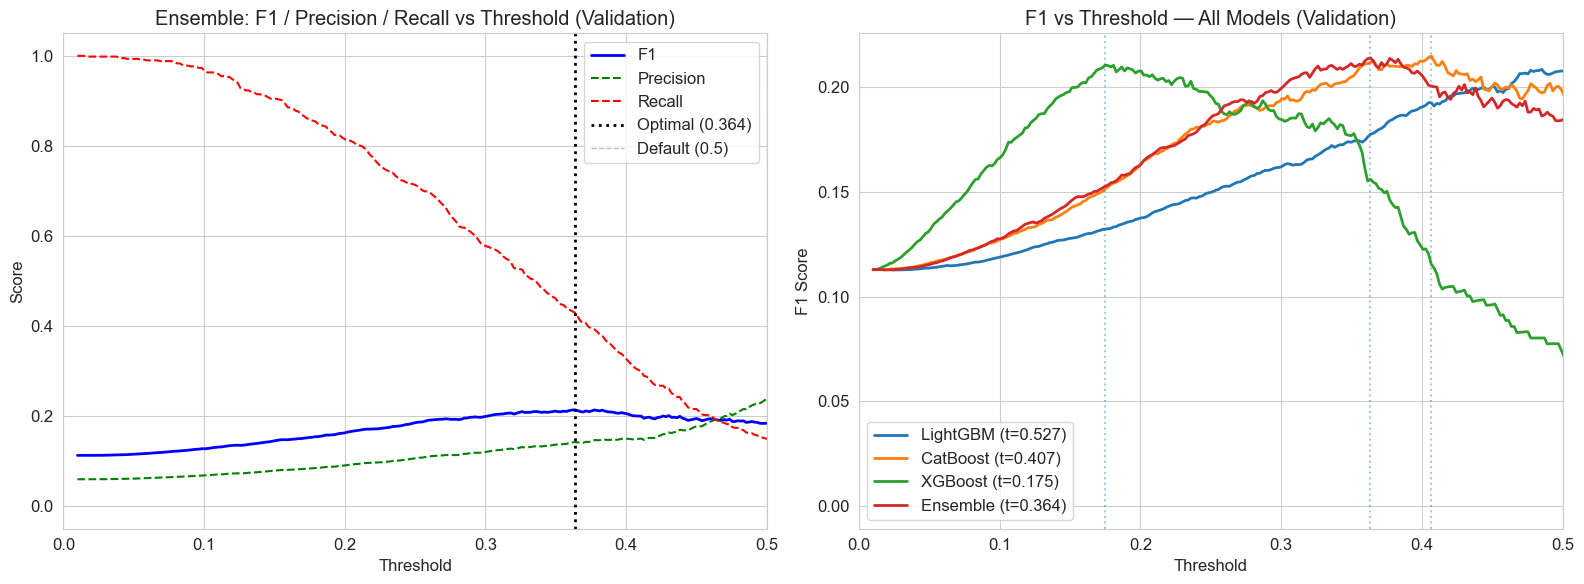


=== APPLYING VALIDATION-TUNED THRESHOLD TO TEST SET ===
Threshold: 0.3635
  LightGBM    : F1=0.1835 | Prec=0.1050 | Rec=0.7249 | TP=851, FP=7252, FN=323, TN=11574
  CatBoost    : F1=0.2139 | Prec=0.1394 | Rec=0.4591 | TP=539, FP=3327, FN=635, TN=15499
  XGBoost     : F1=0.1357 | Prec=0.2655 | Rec=0.0911 | TP=107, FP=296, FN=1067, TN=18530
  Ensemble    : F1=0.2083 | Prec=0.1389 | Rec=0.4165 | TP=489, FP=3032, FN=685, TN=15794

--- Default 0.5 threshold → F1=0.1671
--- Optimized 0.3635 threshold → F1=0.2083
--- Improvement: +0.0412 (24.7%)


In [28]:
# ══════════════════════════════════════════════════════════════════
# STEP 1: Full threshold sweep on VALIDATION set (no data leakage)
# ══════════════════════════════════════════════════════════════════

def find_best_f1_threshold(y_true, y_prob, n_thresholds=500):
    """Search for F1-maximizing threshold over a fine grid."""
    thresholds = np.linspace(0.01, 0.99, n_thresholds)
    results = []
    for t in thresholds:
        preds = (y_prob >= t).astype(int)
        cm = confusion_matrix(y_true, preds)
        tn, fp, fn, tp = cm.ravel()
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec  = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1   = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
        results.append({'threshold': t, 'precision': prec, 'recall': rec, 'f1': f1, 'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn})
    return pd.DataFrame(results)

# Per-model threshold search on VALIDATION set
print('=== PER-MODEL THRESHOLD OPTIMIZATION (on Validation Set) ===')
print()
model_thresholds = {}
for name, val_pred in [('LightGBM', lgbm_val_pred), ('CatBoost', cb_val_pred),
                       ('XGBoost', xgb_val_pred), ('Ensemble', ensemble_val_pred)]:
    sweep = find_best_f1_threshold(y_val, val_pred)
    best_row = sweep.loc[sweep['f1'].idxmax()]
    model_thresholds[name] = best_row['threshold']
    print(f'{name:12s}: Best threshold = {best_row["threshold"]:.4f} → '+
          f'F1={best_row["f1"]:.4f} | Prec={best_row["precision"]:.4f} | Rec={best_row["recall"]:.4f} | '+
          f'TP={int(best_row["tp"])}, FP={int(best_row["fp"])}, FN={int(best_row["fn"])}, TN={int(best_row["tn"])}')

optimal_threshold = model_thresholds['Ensemble']

# ═══════════════════════════════════════════════════════════
# STEP 2: Visualize F1/Precision/Recall vs Threshold curve
# ═══════════════════════════════════════════════════════════
sweep_ens = find_best_f1_threshold(y_val, ensemble_val_pred)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: F1 / Precision / Recall curves
axes[0].plot(sweep_ens['threshold'], sweep_ens['f1'], 'b-', lw=2, label='F1')
axes[0].plot(sweep_ens['threshold'], sweep_ens['precision'], 'g--', lw=1.5, label='Precision')
axes[0].plot(sweep_ens['threshold'], sweep_ens['recall'], 'r--', lw=1.5, label='Recall')
axes[0].axvline(optimal_threshold, color='black', ls=':', lw=2, label=f'Optimal ({optimal_threshold:.3f})')
axes[0].axvline(0.5, color='gray', ls='--', lw=1, alpha=0.5, label='Default (0.5)')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Ensemble: F1 / Precision / Recall vs Threshold (Validation)')
axes[0].legend()
axes[0].set_xlim(0, 0.5)  # focus on relevant range

# Right: All models' F1 curves
for name, val_pred in [('LightGBM', lgbm_val_pred), ('CatBoost', cb_val_pred),
                       ('XGBoost', xgb_val_pred), ('Ensemble', ensemble_val_pred)]:
    sw = find_best_f1_threshold(y_val, val_pred)
    best_t = model_thresholds[name]
    axes[1].plot(sw['threshold'], sw['f1'], lw=2, label=f'{name} (t={best_t:.3f})')
    axes[1].axvline(best_t, ls=':', alpha=0.4)
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('F1 vs Threshold — All Models (Validation)')
axes[1].legend()
axes[1].set_xlim(0, 0.5)
plt.tight_layout()
plt.show()

# ═══════════════════════════════════════════════════════════════════
# STEP 3: Apply validation-tuned threshold to TEST set
# ═══════════════════════════════════════════════════════════════════
print('\n=== APPLYING VALIDATION-TUNED THRESHOLD TO TEST SET ===')
print(f'Threshold: {optimal_threshold:.4f}')
for name, test_pred in [('LightGBM', lgbm_test_pred), ('CatBoost', cb_test_pred),
                        ('XGBoost', xgb_test_pred), ('Ensemble', ensemble_test_pred)]:
    y_pred = (test_pred >= optimal_threshold).astype(int)
    tf1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    prec = tp/(tp+fp) if (tp+fp) > 0 else 0
    rec  = tp/(tp+fn) if (tp+fn) > 0 else 0
    print(f'  {name:12s}: F1={tf1:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | TP={tp}, FP={fp}, FN={fn}, TN={tn}')

# Comparison with default 0.5
y_pred_default = (ensemble_test_pred >= 0.5).astype(int)
f1_default = f1_score(y_test, y_pred_default)
y_pred_opt = (ensemble_test_pred >= optimal_threshold).astype(int)
test_f1_opt = f1_score(y_test, y_pred_opt)
ens_test_f1 = test_f1_opt  # for later use
print(f'\n--- Default 0.5 threshold → F1={f1_default:.4f}')
print(f'--- Optimized {optimal_threshold:.4f} threshold → F1={test_f1_opt:.4f}')
improvement = test_f1_opt - f1_default
pct = (improvement / max(f1_default, 1e-10)) * 100
print(f'--- Improvement: +{improvement:.4f} ({pct:.1f}%)')


### 9.5b Business Scenarios

In [29]:
# Business scenarios using test-set PR curve
prec_vals, rec_vals, thresh_pr = precision_recall_curve(y_test, ensemble_test_pred)

scenarios = {
    'Conservative (High Precision)': {'min_precision': 0.50},
    'Balanced (Validation-Tuned F1)': {'threshold': optimal_threshold},
    'Aggressive (High Recall)': {'min_recall': 0.70}
}

print('\n=== BUSINESS SCENARIOS ===')
for name, config in scenarios.items():
    if 'threshold' in config:
        t = config['threshold']
    elif 'min_precision' in config:
        valid = prec_vals[:-1] >= config['min_precision']
        if valid.any():
            t = thresh_pr[valid][np.argmax(rec_vals[:-1][valid])]
        else:
            t = 0.5
    elif 'min_recall' in config:
        valid = rec_vals[:-1] >= config['min_recall']
        if valid.any():
            t = thresh_pr[valid][np.argmax(prec_vals[:-1][valid])]
        else:
            t = 0.1
    
    y_pred_bin = (ensemble_test_pred >= t).astype(int)
    cm = confusion_matrix(y_test, y_pred_bin)
    tn, fp, fn, tp = cm.ravel()
    prec = tp/(tp+fp) if (tp+fp) > 0 else 0
    rec  = tp/(tp+fn) if (tp+fn) > 0 else 0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec) > 0 else 0
    print(f'\n{name} (threshold={t:.4f}):')
    print(f'  Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}')
    print(f'  TP={tp}, FP={fp}, FN={fn}, TN={tn}')


=== BUSINESS SCENARIOS ===

Conservative (High Precision) (threshold=0.6485):
  Precision=0.5000, Recall=0.0298, F1=0.0563
  TP=35, FP=35, FN=1139, TN=18791

Balanced (Validation-Tuned F1) (threshold=0.3635):
  Precision=0.1389, Recall=0.4165, F1=0.2083
  TP=489, FP=3032, FN=685, TN=15794

Aggressive (High Recall) (threshold=0.2582):
  Precision=0.1111, Recall=0.7002, F1=0.1918
  TP=822, FP=6574, FN=352, TN=12252


### 9.6 Confusion Matrix (Validation-Tuned Threshold)

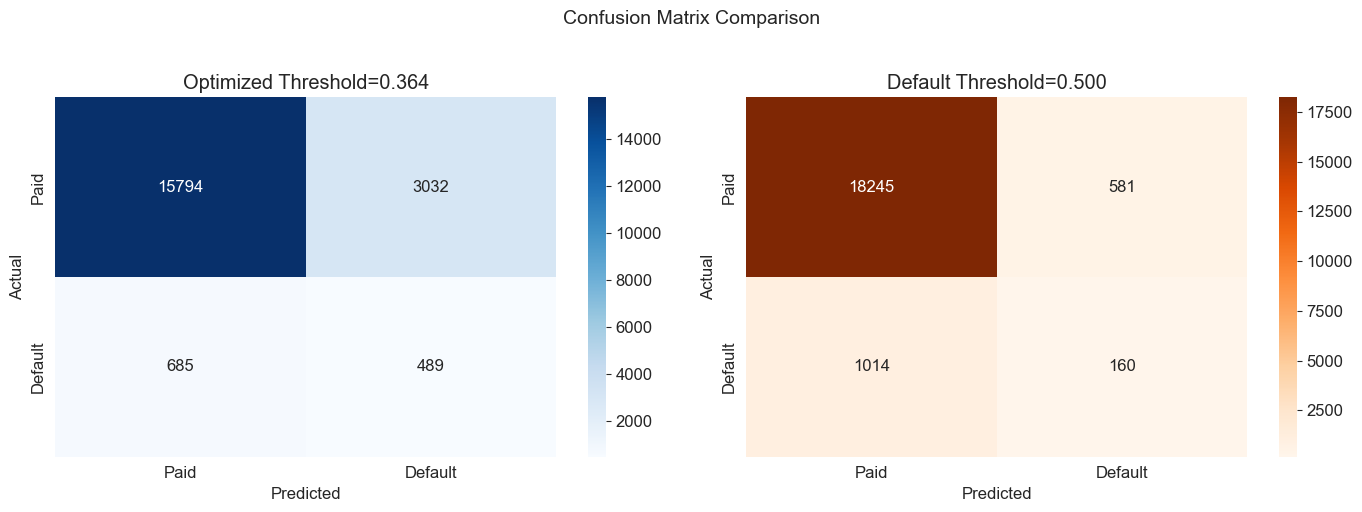

=== Classification Report (Optimized Threshold) ===
              precision    recall  f1-score   support

        Paid       0.96      0.84      0.89     18826
     Default       0.14      0.42      0.21      1174

    accuracy                           0.81     20000
   macro avg       0.55      0.63      0.55     20000
weighted avg       0.91      0.81      0.85     20000

=== Classification Report (Default 0.5 Threshold) ===
              precision    recall  f1-score   support

        Paid       0.95      0.97      0.96     18826
     Default       0.22      0.14      0.17      1174

    accuracy                           0.92     20000
   macro avg       0.58      0.55      0.56     20000
weighted avg       0.90      0.92      0.91     20000



In [30]:
y_pred_best = (ensemble_test_pred >= optimal_threshold).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: with optimized threshold
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Paid','Default'], yticklabels=['Paid','Default'])
axes[0].set_title(f'Optimized Threshold={optimal_threshold:.3f}')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')

# Right: with default 0.5 threshold for comparison
cm_default = confusion_matrix(y_test, (ensemble_test_pred >= 0.5).astype(int))
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Paid','Default'], yticklabels=['Paid','Default'])
axes[1].set_title('Default Threshold=0.500')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')

plt.suptitle('Confusion Matrix Comparison', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print('=== Classification Report (Optimized Threshold) ===')
print(classification_report(y_test, y_pred_best, target_names=['Paid','Default']))

print('=== Classification Report (Default 0.5 Threshold) ===')
print(classification_report(y_test, (ensemble_test_pred >= 0.5).astype(int), target_names=['Paid','Default']))

## 10. SHAP Interpretability

In [31]:
import shap

# Use LightGBM for SHAP (faster TreeExplainer)
explainer = shap.TreeExplainer(final_lgbm)
shap_values = explainer.shap_values(X_test_sel)

# If binary classification, shap_values may be a list of 2 arrays
if isinstance(shap_values, list):
    sv = shap_values[1]  # positive class
else:
    sv = shap_values

print('SHAP values computed.')

SHAP values computed.


### 10.1 SHAP Summary (Global Importance + Direction)

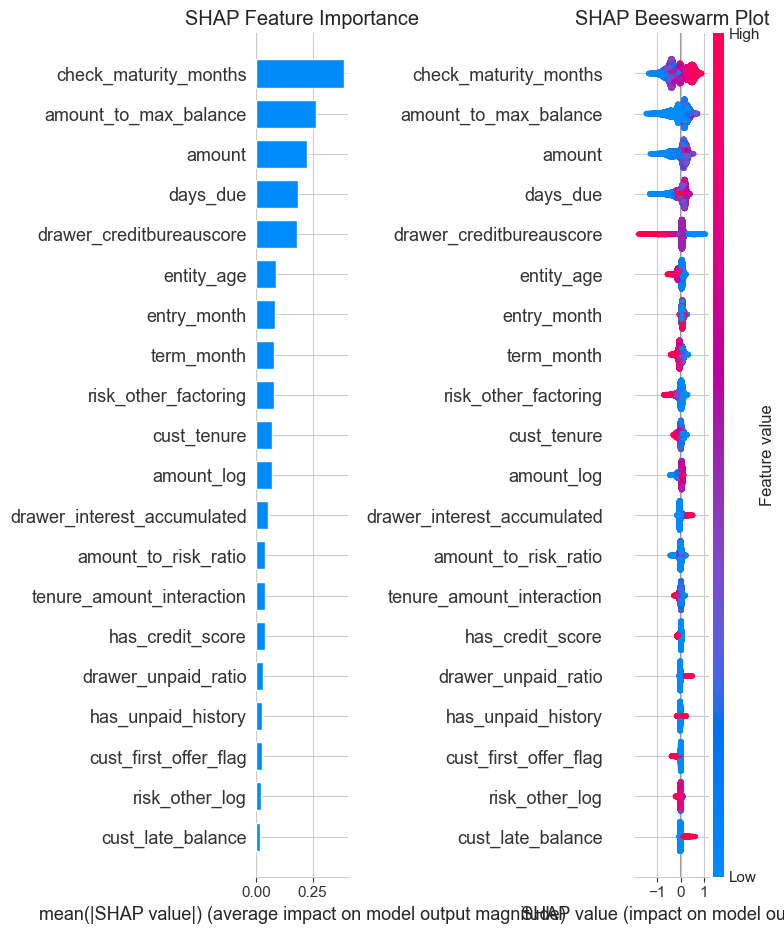

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

plt.sca(axes[0])
shap.summary_plot(sv, X_test_sel, plot_type='bar', show=False, max_display=20)
axes[0].set_title('SHAP Feature Importance')

plt.sca(axes[1])
shap.summary_plot(sv, X_test_sel, show=False, max_display=20)
axes[1].set_title('SHAP Beeswarm Plot')

plt.tight_layout()
plt.show()

### 10.2 SHAP Dependence Plots (Top 4 Features)

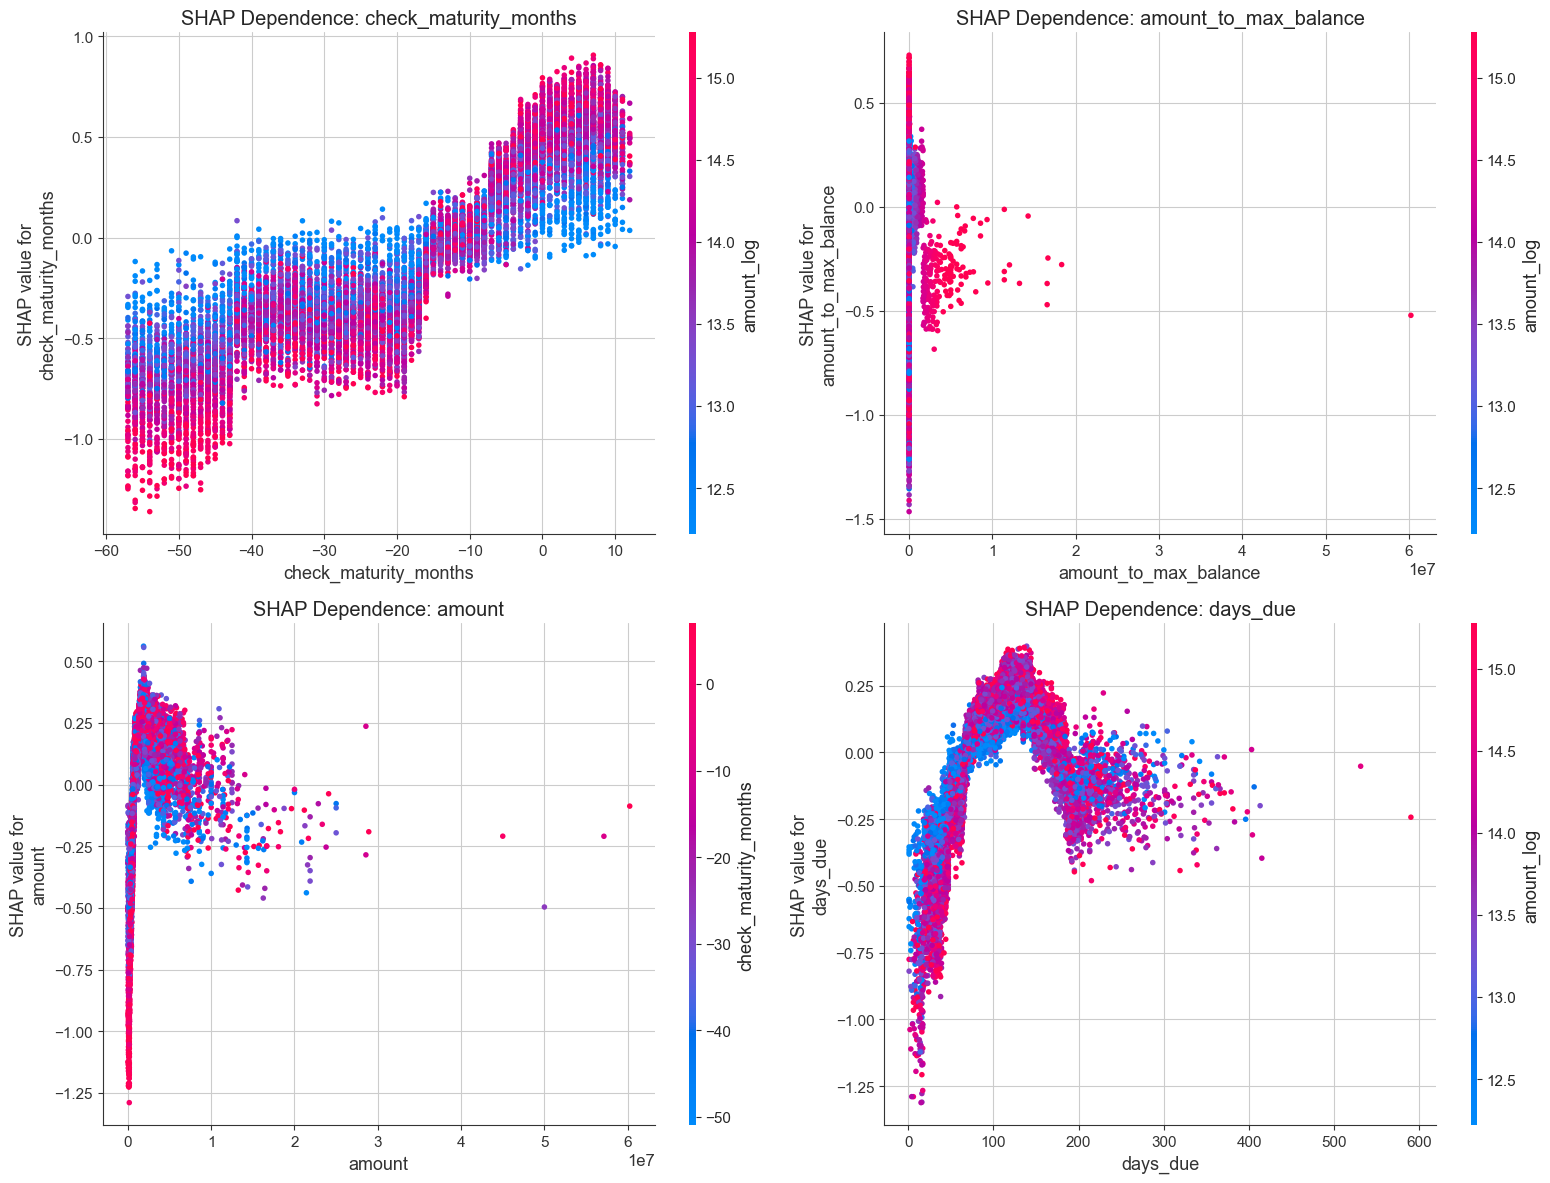

In [33]:
# Top 4 features by mean |SHAP|
mean_shap = np.abs(sv).mean(axis=0)
top4_idx = np.argsort(mean_shap)[-4:][::-1]
top4_names = [X_test_sel.columns[i] for i in top4_idx]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for idx, (feat, ax) in enumerate(zip(top4_names, axes.ravel())):
    plt.sca(ax)
    shap.dependence_plot(feat, sv, X_test_sel, ax=ax, show=False)
    ax.set_title(f'SHAP Dependence: {feat}')
plt.tight_layout()
plt.show()

### 10.3 SHAP Force Plots (Individual Explanations)

--- DEFAULT CASE ---


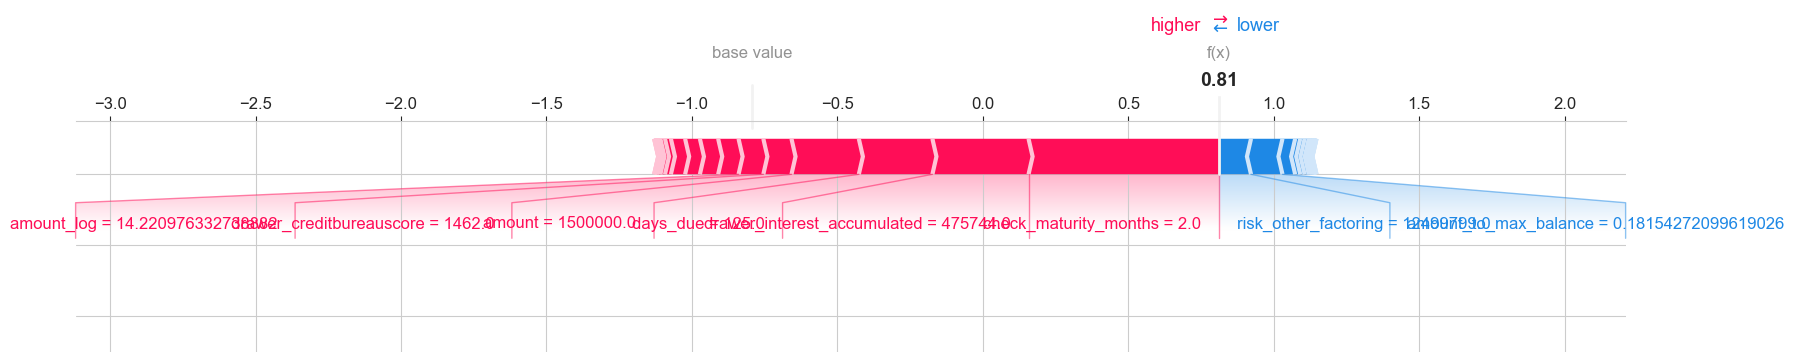

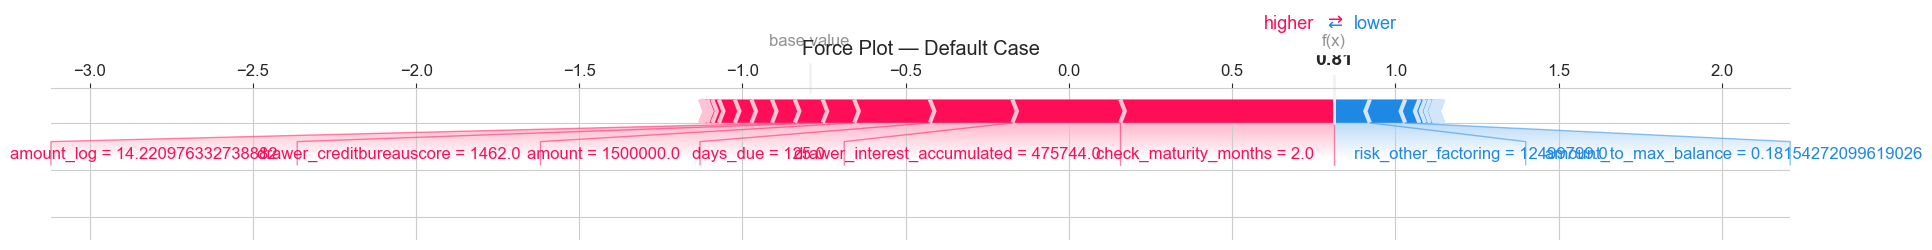


--- PAID CASE ---


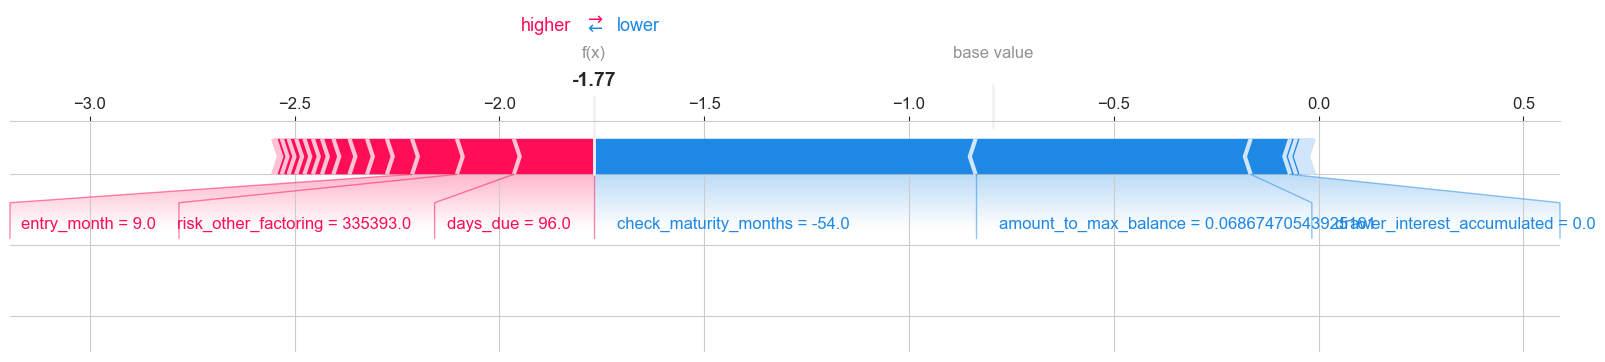

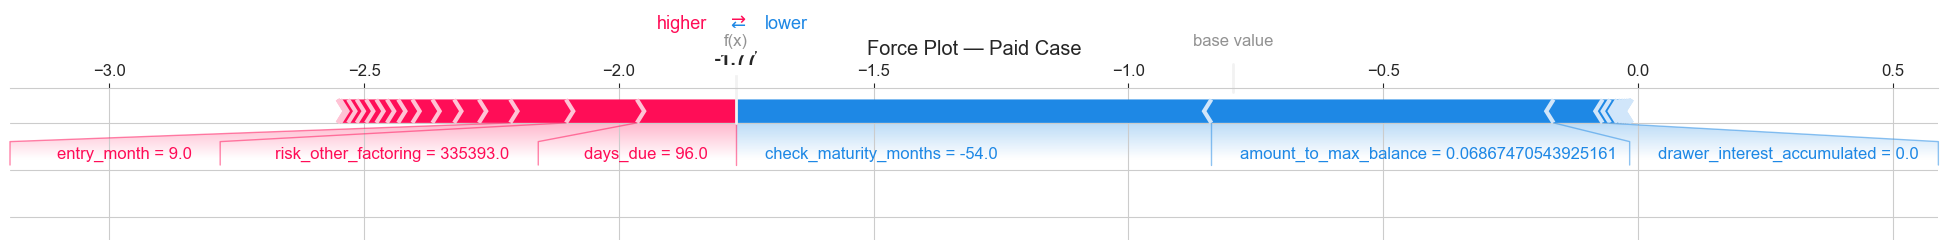

In [34]:
# One default case, one paid case
default_idx = y_test[y_test == 1].index[0] - y_test.index[0]  # relative index
paid_idx = y_test[y_test == 0].index[0] - y_test.index[0]

print('--- DEFAULT CASE ---')
shap.initjs()
display(shap.force_plot(explainer.expected_value if not isinstance(explainer.expected_value, list) else explainer.expected_value[1],
                        sv[default_idx], X_test_sel.iloc[default_idx],
                        matplotlib=True, show=False))
plt.title('Force Plot — Default Case')
plt.tight_layout()
plt.show()

print('\n--- PAID CASE ---')
display(shap.force_plot(explainer.expected_value if not isinstance(explainer.expected_value, list) else explainer.expected_value[1],
                        sv[paid_idx], X_test_sel.iloc[paid_idx],
                        matplotlib=True, show=False))
plt.title('Force Plot — Paid Case')
plt.tight_layout()
plt.show()

## 11. Business Insights & Recommendations

In [35]:
print('=' * 60)
print('BUSINESS INSIGHTS & RECOMMENDATIONS')
print('=' * 60)

# Top risk factors
top_features = pd.Series(np.abs(sv).mean(axis=0), index=X_test_sel.columns).sort_values(ascending=False)
print('\n📊 TOP 10 RISK FACTORS (by SHAP importance):')
for i, (feat, val) in enumerate(top_features.head(10).items(), 1):
    print(f'  {i}. {feat}: {val:.4f}')

# Segment analysis
if 'is_micro_segment' in X_test_sel.columns:
    micro_auc = roc_auc_score(
        y_test[X_test_sel['is_micro_segment']==1],
        ensemble_test_pred[X_test_sel['is_micro_segment']==1]
    ) if (X_test_sel['is_micro_segment']==1).sum() > 50 else np.nan
    sme_auc = roc_auc_score(
        y_test[X_test_sel['is_micro_segment']==0],
        ensemble_test_pred[X_test_sel['is_micro_segment']==0]
    ) if (X_test_sel['is_micro_segment']==0).sum() > 50 else np.nan
    print(f'\n🏢 SEGMENT PERFORMANCE:')
    print(f'  Micro Segment AUC: {micro_auc:.4f}')
    print(f'  SME Segment AUC:   {sme_auc:.4f}')

# Summary
final_auc = roc_auc_score(y_test, ensemble_test_pred)
final_gini = 2 * final_auc - 1
print(f'\n🎯 FINAL MODEL PERFORMANCE:')
print(f'  Test AUC:  {final_auc:.4f}')
print(f'  Test F1:   {ens_test_f1:.4f} (threshold={optimal_threshold:.4f})')
print(f'  Gini:      {final_gini:.4f}')
print(f'  KS:        {ks_stat:.4f}')

print(f'\n💡 RECOMMENDATIONS:')
print('  1. Deploy Ensemble model with Conservative threshold for low false-alarm operation')
print('  2. Consider separate models for Micro vs SME segments for further improvement')
print('  3. Collect credit bureau scores for unscored drawers to improve coverage')
print('  4. Monitor PSI/CSI monthly for concept drift detection')
print('  5. Retrain model quarterly with fresh data')

BUSINESS INSIGHTS & RECOMMENDATIONS

📊 TOP 10 RISK FACTORS (by SHAP importance):
  1. check_maturity_months: 0.3884
  2. amount_to_max_balance: 0.2665
  3. amount: 0.2236
  4. days_due: 0.1872
  5. drawer_creditbureauscore: 0.1816
  6. entity_age: 0.0850
  7. entry_month: 0.0808
  8. term_month: 0.0799
  9. risk_other_factoring: 0.0796
  10. cust_tenure: 0.0698

🏢 SEGMENT PERFORMANCE:
  Micro Segment AUC: 0.7332
  SME Segment AUC:   0.7263

🎯 FINAL MODEL PERFORMANCE:
  Test AUC:  0.7298
  Test F1:   0.2083 (threshold=0.3635)
  Gini:      0.4597
  KS:        0.3539

💡 RECOMMENDATIONS:
  1. Deploy Ensemble model with Conservative threshold for low false-alarm operation
  2. Consider separate models for Micro vs SME segments for further improvement
  3. Collect credit bureau scores for unscored drawers to improve coverage
  4. Monitor PSI/CSI monthly for concept drift detection
  5. Retrain model quarterly with fresh data


---
## Summary

| Metric | Value |
|--------|-------|
| **Validation** | Temporal Split + StratifiedKFold CV (5-fold) |
| **Primary Metric** | ROC-AUC |
| **Imbalance** | `scale_pos_weight` (consistent across baseline & Optuna) |
| **Tuning** | Optuna (50 trials x 3 models = 150 total) |
| **Models** | LightGBM + CatBoost + XGBoost Weighted Ensemble |
| **Stability** | PSI feature drift + CV variance analysis |
| **Key Insight** | Micro/SME segments, MNAR missing flags, Credit Score most important |